---
title: Data Cleaning and EDA (from Spring 2025)
execute:
  echo: true
format:
  html:
    code-fold: true
    code-tools: true
    toc: true
    toc-title: Data Cleaning and EDA
    page-layout: full
    theme:
      - cosmo
      - cerulean
    callout-icon: false
jupyter:
  jupytext:
    text_representation:
      extension: .qmd
      format_name: quarto
      format_version: '1.0'
      jupytext_version: 1.16.1
  kernelspec:
    display_name: data100quarto
    language: python
    name: python3
---

In [1]:
#| code-fold: true
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 9)

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)
# This option stops scientific notation for pandas
pd.set_option('display.float_format', '{:.2f}'.format)

# Silence some spurious seaborn warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

::: {.callout-note collapse="false"}
## Learning Outcomes
* Recognize common file formats
* Categorize data by its variable type
* Build awareness of issues with data faithfulness and develop targeted solutions
:::

In the past few lectures, we've learned that `pandas` is a toolkit to restructure, modify, and explore a dataset. What we haven't yet touched on is *how* to make these data transformation decisions. When we receive a new set of data from the "real world," how do we know what processing we should do to convert this data into a usable form?

**Data cleaning**, also called **data wrangling**, is the process of transforming raw data to facilitate subsequent analysis. It is often used to address issues like:

* Unclear structure or formatting
* Missing or corrupted values
* Unit conversions
* ...and so on

**Exploratory Data Analysis (EDA)** is the process of understanding a new dataset. It is an open-ended, informal analysis that involves familiarizing ourselves with the variables present in the data, discovering potential hypotheses, and identifying possible issues with the data. This last point can often motivate further data cleaning to address any problems with the dataset's format; because of this, EDA and data cleaning are often thought of as an "infinite loop," with each process driving the other.

In this lecture, we will consider the key properties of data to consider when performing data cleaning and EDA. In doing so, we'll develop a "checklist" of sorts for you to consider when approaching a new dataset. Throughout this process, we'll build a deeper understanding of this early (but very important!) stage of the data science lifecycle.

## Structure
We often prefer rectangular data for data analysis. Rectangular structures are easy to manipulate and analyze. A key element of data cleaning is about transforming data to be more rectangular. 

There are two kinds of rectangular data: tables and matrices. Tables have named columns with different data types and are manipulated using data transformation languages. Matrices contain numeric data of the same type and are manipulated using linear algebra.

### File Formats
There are many file types for storing structured data: TSV, JSON, XML, ASCII, SAS, etc. We'll only cover CSV, TSV, and JSON in lecture, but you'll likely encounter other formats as you work with different datasets. Reading documentation is your best bet for understanding how to process the multitude of different file types. 

#### CSV
CSVs, which stand for **Comma-Separated Values**, are a common tabular data format. 
In the past two `pandas` lectures, we briefly touched on the idea of file format: the way data is encoded in a file for storage. Specifically, our `elections` and `babynames` datasets were stored and loaded as CSVs:

In [2]:
#| code-fold: false
pd.read_csv("data/elections.csv").head(5)

,Year,Candidate,Party,Popular vote,Result,%
0,1824,Andrew Jackson,Democratic-Republican,151271,loss,57.21
1,1824,John Quincy Adams,Democratic-Republican,113142,win,42.79
2,1828,Andrew Jackson,Democratic,642806,win,56.20
3,1828,John Quincy Adams,National Republican,500897,loss,43.80
4,1832,Andrew Jackson,Democratic,702735,win,54.57


To better understand the properties of a CSV, let's take a look at the first few rows of the raw data file to see what it looks like before being loaded into a `DataFrame`. We'll use the `repr()` function to return the raw string with its special characters: 

In [3]:
#| code-fold: false
with open("data/elections.csv", "r") as table:
    i = 0
    for row in table:
        print(repr(row))
        i += 1
        if i > 3:
            break

'Year,Candidate,Party,Popular vote,Result,%\n'
'1824,Andrew Jackson,Democratic-Republican,151271,loss,57.21012204\n'
'1824,John Quincy Adams,Democratic-Republican,113142,win,42.78987796\n'
'1828,Andrew Jackson,Democratic,642806,win,56.20392707\n'


Each row, or **record**, in the data is delimited by a newline `\n`. Each column, or **field**, in the data is delimited by a comma `,` (hence, comma-separated!). 

#### TSV

Another common file type is **TSV (Tab-Separated Values)**. In a TSV, records are still delimited by a newline `\n`, while fields are delimited by `\t` tab character. 

Let's check out the first few rows of the raw TSV file. Again, we'll use the `repr()` function so that `print` shows the special characters.

In [4]:
#| code-fold: false
with open("data/elections.txt", "r") as table:
    i = 0
    for row in table:
        print(repr(row))
        i += 1
        if i > 3:
            break

'\ufeffYear\tCandidate\tParty\tPopular vote\tResult\t%\n'
'1824\tAndrew Jackson\tDemocratic-Republican\t151271\tloss\t57.21012204\n'
'1824\tJohn Quincy Adams\tDemocratic-Republican\t113142\twin\t42.78987796\n'
'1828\tAndrew Jackson\tDemocratic\t642806\twin\t56.20392707\n'


TSVs can be loaded into `pandas` using `pd.read_csv`. We'll need to specify the **delimiter** with parameter` sep='\t'` [(documentation)](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html).

In [5]:
#| code-fold: false
pd.read_csv("data/elections.txt", sep='\t').head(3)

,Year,Candidate,Party,Popular vote,Result,%
0,1824,Andrew Jackson,Democratic-Republican,151271,loss,57.21
1,1824,John Quincy Adams,Democratic-Republican,113142,win,42.79
2,1828,Andrew Jackson,Democratic,642806,win,56.20


An issue with CSVs and TSVs comes up whenever there are commas or tabs within the records. How does `pandas` differentiate between a comma delimiter vs. a comma within the field itself, for example `8,900`? To remedy this, check out the [`quotechar` parameter](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html). 

#### JSON
**JSON (JavaScript Object Notation)** files behave similarly to Python dictionaries. A raw JSON is shown below.

In [6]:
#| code-fold: false
with open("data/elections.json", "r") as table:
    i = 0
    for row in table:
        print(row)
        i += 1
        if i > 8:
            break

[

 {

   "Year": 1824,

   "Candidate": "Andrew Jackson",

   "Party": "Democratic-Republican",

   "Popular vote": 151271,

   "Result": "loss",

   "%": 57.21012204

 },



JSON files can be loaded into `pandas` using `pd.read_json`. 

In [7]:
#| code-fold: false
pd.read_json('data/elections.json').head(3)

,Year,Candidate,Party,Popular vote,Result,%
0,1824,Andrew Jackson,Democratic-Republican,151271,loss,57.21
1,1824,John Quincy Adams,Democratic-Republican,113142,win,42.79
2,1828,Andrew Jackson,Democratic,642806,win,56.20


##### EDA with JSON: Berkeley COVID-19 Data
The City of Berkeley Open Data [website](https://data.cityofberkeley.info/Health/COVID-19-Confirmed-Cases/xn6j-b766) has a dataset with COVID-19 Confirmed Cases among Berkeley residents by date. Let's download the file and save it as a JSON (note the source URL file type is also a JSON). In the interest of reproducible data science, we will download the data programatically. We have defined some helper functions in the [`ds100_utils.py`](https://ds100.org/fa23/resources/assets/lectures/lec05/lec05-eda.html) file that we can reuse these helper functions in many different notebooks.

In [8]:
#| code-fold: false
from ds100_utils import fetch_and_cache

covid_file = fetch_and_cache(
    "https://data.cityofberkeley.info/api/views/xn6j-b766/rows.json?accessType=DOWNLOAD",
    "confirmed-cases.json",
    force=False)
covid_file          # a file path wrapper object

Using cached version that was downloaded (UTC): Fri Jun 20 15:20:11 2025


PosixPath('data/confirmed-cases.json')

###### File Size
Let's start our analysis by getting a rough estimate of the size of the dataset to inform the tools we use to view the data. For relatively small datasets, we can use a text editor or spreadsheet. For larger datasets, more programmatic exploration or distributed computing tools may be more fitting. Here we will use `Python` tools to probe the file.

Since there seem to be text files, let's investigate the number of lines, which often corresponds to the number of records

In [9]:
#| code-fold: false
import os

print(covid_file, "is", os.path.getsize(covid_file) / 1e6, "MB")

with open(covid_file, "r") as f:
    print(covid_file, "is", sum(1 for l in f), "lines.")

data/confirmed-cases.json is 0.116367 MB
data/confirmed-cases.json is 1110 lines.


###### Unix Commands
As part of the EDA workflow, Unix commands can come in very handy. In fact, there's an entire book called ["Data Science at the Command Line"](https://datascienceatthecommandline.com/) that explores this idea in depth! 
In Jupyter/IPython, you can prefix lines with `!` to execute arbitrary Unix commands, and within those lines, you can refer to Python variables and expressions with the syntax `{expr}`.

Here, we use the `ls` command to list files, using the `-lh` flags, which request "long format with information in human-readable form." We also use the `wc` command for "word count," but with the `-l` flag, which asks for line counts instead of words.

These two give us the same information as the code above, albeit in a slightly different form:

In [10]:
#| code-fold: false
!ls -lh {covid_file}
!wc -l {covid_file}

-rw-r--r--  1 wkz  staff   114K Jun 20 15:20 data/confirmed-cases.json


    1109 data/confirmed-cases.json


###### File Contents
Let's explore the data format using `Python`. 

In [11]:
#| code-fold: false
with open(covid_file, "r") as f:
    for i, row in enumerate(f):
        print(repr(row)) # print raw strings
        if i >= 4: break

'{\n'
'  "meta" : {\n'
'    "view" : {\n'
'      "id" : "xn6j-b766",\n'
'      "name" : "COVID-19 Confirmed Cases",\n'


We can use the `head` Unix command (which is where `pandas`' `head` method comes from!) to see the first few lines of the file:

In [12]:
#| code-fold: false
!head -5 {covid_file}

{
  "meta" : {
    "view" : {
      "id" : "xn6j-b766",
      "name" : "COVID-19 Confirmed Cases",


In order to load the JSON file into `pandas`, Let's first do some EDA with Python's `json` package to understand the particular structure of this JSON file so that we can decide what (if anything) to load into `pandas`. Python has relatively good support for JSON data since it closely matches the internal python object model. In the following cell we import the entire JSON datafile into a python dictionary using the `json` package.

In [13]:
#| code-fold: false
import json

with open(covid_file, "rb") as f:
    covid_json = json.load(f)

The `covid_json` variable is now a dictionary encoding the data in the file:

In [14]:
#| code-fold: false
type(covid_json)

dict

We can examine what keys are in the top level JSON object by listing out the keys. 

In [15]:
#| code-fold: false
covid_json.keys()

dict_keys(['meta', 'data'])

**Observation**: The JSON dictionary contains a `meta` key which likely refers to metadata (data about the data).  Metadata is often maintained with the data and can be a good source of additional information.


We can investigate the metadata further by examining the keys associated with the metadata.

In [16]:
#| code-fold: false
covid_json['meta'].keys()

dict_keys(['view'])

The `meta` key contains another dictionary called `view`.  This likely refers to metadata about a particular "view" of some underlying database. We will learn more about views when we study SQL later in the class.    

In [17]:
#| code-fold: false
covid_json['meta']['view'].keys()

dict_keys(['id', 'name', 'assetType', 'attribution', 'averageRating', 'category', 'createdAt', 'description', 'displayType', 'downloadCount', 'hideFromCatalog', 'hideFromDataJson', 'newBackend', 'numberOfComments', 'oid', 'provenance', 'publicationAppendEnabled', 'publicationDate', 'publicationGroup', 'publicationStage', 'rowsUpdatedAt', 'rowsUpdatedBy', 'tableId', 'totalTimesRated', 'viewCount', 'viewLastModified', 'viewType', 'approvals', 'columns', 'grants', 'metadata', 'owner', 'query', 'rights', 'tableAuthor', 'tags', 'flags'])

Notice that this a nested/recursive data structure.  As we dig deeper we reveal more and more keys and the corresponding data:

```
meta
|-> data
    | ... (haven't explored yet)
|-> view
    | -> id
    | -> name
    | -> attribution 
    ...
    | -> description
    ...
    | -> columns
    ...
```


There is a key called description in the view sub dictionary.  This likely contains a description of the data:

In [18]:
#| code-fold: false
print(covid_json['meta']['view']['description'])

Counts of confirmed COVID-19 cases among Berkeley residents by date.


###### Examining the Data Field for Records

We can look at a few entries in the `data` field. This is what we'll load into `pandas`.

In [19]:
#| code-fold: false
for i in range(3):
    print(f"{i:03} | {covid_json['data'][i]}")

000 | ['row-kzbg.v7my-c3y2', '00000000-0000-0000-0405-CB14DE51DAA7', 0, 1643733903, None, 1643733903, None, '{ }', '2020-02-28T00:00:00', '1', '1']
001 | ['row-jkyx_9u4r-h2yw', '00000000-0000-0000-F806-86D0DBE0E17F', 0, 1643733903, None, 1643733903, None, '{ }', '2020-02-29T00:00:00', '0', '1']
002 | ['row-qifg_4aug-y3ym', '00000000-0000-0000-2DCE-4D1872F9B216', 0, 1643733903, None, 1643733903, None, '{ }', '2020-03-01T00:00:00', '0', '1']


Observations:

* These look like equal-length records, so maybe `data` is a table!
* But what do each of values in the record mean? Where can we find column headers?

For that, we'll need the `columns` key in the metadata dictionary. This returns a list: 

In [20]:
#| code-fold: false
type(covid_json['meta']['view']['columns'])

list

###### Summary of exploring the JSON file

1. The above **metadata** tells us a lot about the columns in the data including column names, potential data anomalies, and a basic statistic. 
1. Because of its non-tabular structure, JSON makes it easier (than CSV) to create **self-documenting data**, meaning that information about the data is stored in the same file as the data.
1. Self-documenting data can be helpful since it maintains its own description and these descriptions are more likely to be updated as data changes. 

###### Loading COVID Data into `pandas`
Finally, let's load the data (not the metadata) into a `pandas` `DataFrame`. In the following block of code we:

1. Translate the JSON records into a `DataFrame`:

    * fields: `covid_json['meta']['view']['columns']`
    * records: `covid_json['data']`

    
1. Remove columns that have no metadata description.  This would be a bad idea in general, but here we remove these columns since the above analysis suggests they are unlikely to contain useful information.
   
1. Examine the `tail` of the table.

In [21]:
#| code-fold: false
# Load the data from JSON and assign column titles
covid = pd.DataFrame(
    covid_json['data'],
    columns=[c['name'] for c in covid_json['meta']['view']['columns']])

covid.tail()

,sid,id,position,created_at,created_meta,updated_at,updated_meta,meta,Date,New Cases,Cumulative Cases
699,row-49b6_x8zv.gyum,00000000-0000-0000-A18C-9174A6D05774,0,1643733903,None,1643733903,None,{ },2022-01-27T00:00:00,106,10694
700,row-gs55-p5em.y4v9,00000000-0000-0000-F41D-5724AEABB4D6,0,1643733903,None,1643733903,None,{ },2022-01-28T00:00:00,223,10917
701,row-3pyj.tf95-qu67,00000000-0000-0000-BEE3-B0188D2518BD,0,1643733903,None,1643733903,None,{ },2022-01-29T00:00:00,139,11056
702,row-cgnd.8syv.jvjn,00000000-0000-0000-C318-63CF75F7F740,0,1643733903,None,1643733903,None,{ },2022-01-30T00:00:00,33,11089
703,row-qywv_24x6-237y,00000000-0000-0000-FE92-9789FED3AA20,0,1643733903,None,1643733903,None,{ },2022-01-31T00:00:00,42,11131


### Variable Types

Variables are columns. A variable is a measurement of a particular concept. Variables have two common properties: data type/storage type and variable type/feature type. The data type of a variable indicates how each variable value is stored in memory (integer, floating point, boolean, etc.) and affects which `pandas` functions are used. The variable type is a conceptualized measurement of information (and therefore indicates what values a variable can take on). Variable type is identified through expert knowledge, exploring the data itself, or consulting the data codebook. The variable type affects how one visualizes and inteprets the data. In this class, "variable types" are conceptual.

After loading data into a file, it's a good idea to take the time to understand what pieces of information are encoded in the dataset. In particular, we want to identify what variable types are present in our data. Broadly speaking, we can categorize variables into one of two overarching types. 

**Quantitative variables** describe some numeric quantity or amount. Some examples include weights, GPA, CO<sub>2</sub> concentrations, someone's age, or the number of siblings they have.

**Qualitative variables**, also known as **categorical variables**, describe data that isn't measuring some quantity or amount. The sub-categories of categorical data are:

* **Ordinal qualitative variables**: categories with ordered levels. Specifically, ordinal variables are those where the difference between levels has no consistent, quantifiable meaning. Some examples include levels of education (high school, undergrad, grad, etc.), income bracket (low, medium, high), or Yelp rating. 
* **Nominal qualitative variables**: categories with no specific order. For example, someone's political affiliation or Cal ID number.

![Classification of variable types](images/variable_types.png)

Note that many variables don't sit neatly in just one of these categories. Qualitative variables could have numeric levels, and conversely, quantitative variables could be stored as strings. 

## Granularity and Temporality

After understanding the structure of the dataset, the next task is to determine what exactly the data represents. We'll do so by considering the data's granularity and temporality.

### Granularity
The **granularity** of a dataset is what a single row represents. You can also think of it as the level of detail included in the data. To determine the data's granularity, ask: what does each row in the dataset represent? Fine-grained data contains a high level of detail, with a single row representing a small individual unit. For example, each record may represent one person. Coarse-grained data is encoded such that a single row represents a large individual unit – for example, each record may represent a group of people.

### Temporality
The **temporality** of a dataset describes the periodicity over which the data was collected as well as when the data was most recently collected or updated. 

Time and date fields of a dataset could represent a few things:

1. when the "event" happened
2. when the data was collected, or when it was entered into the system
3. when the data was copied into the database 

To fully understand the temporality of the data, it also may be necessary to standardize time zones or inspect recurring time-based trends in the data (do patterns recur in 24-hour periods? Over the course of a month? Seasonally?). The convention for standardizing time is the Coordinated Universal Time (UTC), an international time standard measured at 0 degrees latitude that stays consistent throughout the year (no daylight savings). We can represent Berkeley's time zone, Pacific Standard Time (PST), as UTC-7 (with daylight savings). 

#### Temporality with `pandas`' `dt` accessors 
Let's briefly look at how we can use `pandas`' `dt` accessors to work with dates/times in a dataset using the dataset you'll see in Lab 3: the Berkeley PD Calls for Service dataset.

In [22]:
#| code-fold: true
calls = pd.read_csv("data/Berkeley_PD_-_Calls_for_Service.csv")
calls.head()

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State
0,21014296,THEFT MISD. (UNDER $950),04/01/2021 12:00:00 AM,10:58,LARCENY,4,06/15/2021 12:00:00 AM,"Berkeley, CA\n(37.869058, -122.270455)",NaN,Berkeley,CA
1,21014391,THEFT MISD. (UNDER $950),04/01/2021 12:00:00 AM,10:38,LARCENY,4,06/15/2021 12:00:00 AM,"Berkeley, CA\n(37.869058, -122.270455)",NaN,Berkeley,CA
2,21090494,THEFT MISD. (UNDER $950),04/19/2021 12:00:00 AM,12:15,LARCENY,1,06/15/2021 12:00:00 AM,"2100 BLOCK HASTE ST\nBerkeley, CA\n(37.864908,...",2100 BLOCK HASTE ST,Berkeley,CA
3,21090204,THEFT FELONY (OVER $950),02/13/2021 12:00:00 AM,17:00,LARCENY,6,06/15/2021 12:00:00 AM,"2600 BLOCK WARRING ST\nBerkeley, CA\n(37.86393...",2600 BLOCK WARRING ST,Berkeley,CA
4,21090179,BURGLARY AUTO,02/08/2021 12:00:00 AM,6:20,BURGLARY - VEHICLE,1,06/15/2021 12:00:00 AM,"2700 BLOCK GARBER ST\nBerkeley, CA\n(37.86066,...",2700 BLOCK GARBER ST,Berkeley,CA


Looks like there are three columns with dates/times: `EVENTDT`, `EVENTTM`, and `InDbDate`. 

Most likely, `EVENTDT` stands for the date when the event took place, `EVENTTM` stands for the time of day the event took place (in 24-hr format), and `InDbDate` is the date this call is recorded onto the database.

If we check the data type of these columns, we will see they are stored as strings. We can convert them to `datetime` objects using pandas `to_datetime` function.

In [23]:
#| code-fold: false
calls["EVENTDT"] = pd.to_datetime(calls["EVENTDT"])
calls.head()

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State
0,21014296,THEFT MISD. (UNDER $950),2021-04-01,10:58,LARCENY,4,06/15/2021 12:00:00 AM,"Berkeley, CA\n(37.869058, -122.270455)",NaN,Berkeley,CA
1,21014391,THEFT MISD. (UNDER $950),2021-04-01,10:38,LARCENY,4,06/15/2021 12:00:00 AM,"Berkeley, CA\n(37.869058, -122.270455)",NaN,Berkeley,CA
2,21090494,THEFT MISD. (UNDER $950),2021-04-19,12:15,LARCENY,1,06/15/2021 12:00:00 AM,"2100 BLOCK HASTE ST\nBerkeley, CA\n(37.864908,...",2100 BLOCK HASTE ST,Berkeley,CA
3,21090204,THEFT FELONY (OVER $950),2021-02-13,17:00,LARCENY,6,06/15/2021 12:00:00 AM,"2600 BLOCK WARRING ST\nBerkeley, CA\n(37.86393...",2600 BLOCK WARRING ST,Berkeley,CA
4,21090179,BURGLARY AUTO,2021-02-08,6:20,BURGLARY - VEHICLE,1,06/15/2021 12:00:00 AM,"2700 BLOCK GARBER ST\nBerkeley, CA\n(37.86066,...",2700 BLOCK GARBER ST,Berkeley,CA


Now, we can use the `dt` accessor on this column.

We can get the month: 

In [24]:
#| code-fold: false
calls["EVENTDT"].dt.month.head()

0    4
1    4
2    4
3    2
4    2
Name: EVENTDT, dtype: int32

Which day of the week the date is on:

In [25]:
#| code-fold: false
calls["EVENTDT"].dt.dayofweek.head()

0    3
1    3
2    0
3    5
4    0
Name: EVENTDT, dtype: int32

Check the mimimum values to see if there are any suspicious-looking, 70s dates:

In [26]:
#| code-fold: false
calls.sort_values("EVENTDT").head()

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State
2513,20057398,BURGLARY COMMERCIAL,2020-12-17,16:05,BURGLARY - COMMERCIAL,4,06/15/2021 12:00:00 AM,"600 BLOCK GILMAN ST\nBerkeley, CA\n(37.878405,...",600 BLOCK GILMAN ST,Berkeley,CA
624,20057207,ASSAULT/BATTERY MISD.,2020-12-17,16:50,ASSAULT,4,06/15/2021 12:00:00 AM,"2100 BLOCK SHATTUCK AVE\nBerkeley, CA\n(37.871...",2100 BLOCK SHATTUCK AVE,Berkeley,CA
154,20092214,THEFT FROM AUTO,2020-12-17,18:30,LARCENY - FROM VEHICLE,4,06/15/2021 12:00:00 AM,"800 BLOCK SHATTUCK AVE\nBerkeley, CA\n(37.8918...",800 BLOCK SHATTUCK AVE,Berkeley,CA
659,20057324,THEFT MISD. (UNDER $950),2020-12-17,15:44,LARCENY,4,06/15/2021 12:00:00 AM,"1800 BLOCK 4TH ST\nBerkeley, CA\n(37.869888, -...",1800 BLOCK 4TH ST,Berkeley,CA
993,20057573,BURGLARY RESIDENTIAL,2020-12-17,22:15,BURGLARY - RESIDENTIAL,4,06/15/2021 12:00:00 AM,"1700 BLOCK STUART ST\nBerkeley, CA\n(37.857495...",1700 BLOCK STUART ST,Berkeley,CA


Doesn't look like it! We are good!


We can also do many things with the `dt` accessor like switching time zones and converting time back to UNIX/POSIX time. Check out the documentation on [`.dt` accessor](https://pandas.pydata.org/docs/user_guide/basics.html#basics-dt-accessors) and [time series/date functionality](https://pandas.pydata.org/docs/user_guide/timeseries.html#).

## Faithfulness

At this stage in our data cleaning and EDA workflow, we've achieved quite a lot: we've identified how our data is structured, come to terms with what information it encodes, and gained insight as to how it was generated. Throughout this process, we should always recall the original intent of our work in Data Science – to use data to better understand and model the real world. To achieve this goal, we need to ensure that the data we use is faithful to reality; that is, that our data accurately captures the "real world."

Data used in research or industry is often "messy" – there may be errors or inaccuracies that impact the faithfulness of the dataset. Signs that data may not be faithful include:

* Unrealistic or "incorrect" values, such as negative counts, locations that don't exist, or dates set in the future
* Violations of obvious dependencies, like an age that does not match a birthday
* Clear signs that data was entered by hand, which can lead to spelling errors or fields that are incorrectly shifted
* Signs of data falsification, such as fake email addresses or repeated use of the same names
* Duplicated records or fields containing the same information
* Truncated data, e.g. Microsoft Excel would limit the number of rows to 655536 and the number of columns to 255

We often solve some of these more common issues in the following ways: 

* Spelling errors: apply corrections or drop records that aren't in a dictionary
* Time zone inconsistencies: convert to a common time zone (e.g. UTC) 
* Duplicated records or fields: identify and eliminate duplicates (using primary keys)
* Unspecified or inconsistent units: infer the units and check that values are in reasonable ranges in the data

### Missing Values
Another common issue encountered with real-world datasets is that of missing data. One strategy to resolve this is to simply drop any records with missing values from the dataset. This does, however, introduce the risk of inducing biases – it is possible that the missing or corrupt records may be systemically related to some feature of interest in the data. Another solution is to keep the data as `NaN` values. 

A third method to address missing data is to perform **imputation**: infer the missing values using other data available in the dataset. There is a wide variety of imputation techniques that can be implemented; some of the most common are listed below.

* Average imputation: replace missing values with the average value for that field
* Hot deck imputation: replace missing values with some random value
* Regression imputation: develop a model to predict missing values and replace with the predicted value from the model.
* Multiple imputation: replace missing values with multiple random values

Regardless of the strategy used to deal with missing data, we should think carefully about *why* particular records or fields may be missing – this can help inform whether or not the absence of these values is significant or meaningful.

## EDA Demo 1: Tuberculosis in the United States

Now, let's walk through the data-cleaning and EDA workflow to see what can we learn about the presence of Tuberculosis in the United States!

We will examine the data included in the [original CDC article](https://www.cdc.gov/mmwr/volumes/71/wr/mm7112a1.htm?s_cid=mm7112a1_w#T1_down) published in 2021.


### CSVs and Field Names
Suppose Table 1 was saved as a CSV file located in `data/cdc_tuberculosis.csv`.

We can then explore the CSV (which is a text file, and does not contain binary-encoded data) in many ways:
1. Using a text editor like emacs, vim, VSCode, etc.
2. Opening the CSV directly in DataHub (read-only), Excel, Google Sheets, etc.
3. The `Python` file object
4. `pandas`, using `pd.read_csv()`

To try out options 1 and 2, you can view or download the Tuberculosis from the [lecture demo notebook](https://data100.datahub.berkeley.edu/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2FDS-100%2Fsp25-student&urlpath=lab%2Ftree%2Fsp25-student%2Flecture%2Flec05%2Flec05-part-1-eda-tuberculosis.ipynb&branch=main) under the `data` folder in the left hand menu. Notice how the CSV file is a type of **rectangular data (i.e., tabular data) stored as comma-separated values**.

Next, let's try out option 3 using the `Python` file object. We'll look at the first four lines:

In [27]:
#| code-fold: true
with open("data/cdc_tuberculosis.csv", "r") as f:
    i = 0
    for row in f:
        print(row)
        i += 1
        if i > 3:
            break

,No. of TB cases,,

U.S. jurisdiction,2019,2020,2021

Total,"8,900","7,173","7,860"

Alabama,87,72,92



Whoa, why are there blank lines interspaced between the lines of the CSV?

You may recall that all line breaks in text files are encoded as the special newline character `\n`. Python's `print()` prints each string (including the newline), and an additional newline on top of that.

If you're curious, we can use the `repr()` function to return the raw string with all special characters:

In [28]:
#| code-fold: true
with open("data/cdc_tuberculosis.csv", "r") as f:
    i = 0
    for row in f:
        print(repr(row)) # print raw strings
        i += 1
        if i > 3:
            break

',No. of TB cases,,\n'
'U.S. jurisdiction,2019,2020,2021\n'
'Total,"8,900","7,173","7,860"\n'
'Alabama,87,72,92\n'


Finally, let's try option 4 and use the tried-and-true Data 100 approach: `pandas`.

In [29]:
#| code-fold: false
tb_df = pd.read_csv("data/cdc_tuberculosis.csv")
tb_df.head()

,Unnamed: 0,No. of TB cases,Unnamed: 2,Unnamed: 3
0,U.S. jurisdiction,2019,2020,2021
1,Total,"8,900","7,173","7,860"
2,Alabama,87,72,92
3,Alaska,58,58,58
4,Arizona,183,136,129


You may notice some strange things about this table: what's up with the "Unnamed" column names and the first row? 

Congratulations — you're ready to wrangle your data! Because of how things are stored, we'll need to clean the data a bit to name our columns better.

A reasonable first step is to identify the row with the right header. The `pd.read_csv()` function ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html)) has the convenient `header` parameter that we can set to use the elements in row 1 as the appropriate columns:

In [30]:
#| code-fold: false
tb_df = pd.read_csv("data/cdc_tuberculosis.csv", header=1) # row index
tb_df.head(5)

,U.S. jurisdiction,2019,2020,2021
0,Total,"8,900","7,173","7,860"
1,Alabama,87,72,92
2,Alaska,58,58,58
3,Arizona,183,136,129
4,Arkansas,64,59,69


### Record Granularity

You might already be wondering: what's up with that first record?

Row 0 is what we call a **rollup record**, or summary record. It's often useful when displaying tables to humans. The **granularity** of record 0 (Totals) vs the rest of the records (States) is different.

Okay, EDA step two. How was the rollup record aggregated?

Let's check if Total TB cases is the sum of all state TB cases. If we sum over all rows, we should get **2x** the total cases in each of our TB cases by year (why do you think this is?).

In [31]:
#| code-fold: true
tb_df.sum(axis=0)

U.S. jurisdiction    TotalAlabamaAlaskaArizonaArkansasCaliforniaCol...
2019                 8,9008758183642,111666718245583029973261085237...
2020                 7,1737258136591,706525417194122219282169239376...
2021                 7,8609258129691,750585443194992281064255127494...
dtype: object

Whoa, what's going on with the TB cases in 2019, 2020, and 2021? Check out the column types:

In [32]:
#| code-fold: true
tb_df.dtypes

U.S. jurisdiction    object
2019                 object
2020                 object
2021                 object
dtype: object

Since there are commas in the values for TB cases, the numbers are read as the `object` datatype, or **storage type** (close to the `Python` string datatype), so `pandas` is concatenating strings instead of adding integers (recall that Python can "sum", or concatenate, strings together: `"data" + "100"` evaluates to `"data100"`). 


Fortunately `read_csv` also has a `thousands` parameter ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html)):

In [33]:
#| code-fold: false
# improve readability: chaining method calls with outer parentheses/line breaks
tb_df = (
    pd.read_csv("data/cdc_tuberculosis.csv", header=1, thousands=',')
)
tb_df.head(5)

,U.S. jurisdiction,2019,2020,2021
0,Total,8900,7173,7860
1,Alabama,87,72,92
2,Alaska,58,58,58
3,Arizona,183,136,129
4,Arkansas,64,59,69


In [34]:
#| code-fold: false
tb_df.sum()

U.S. jurisdiction    TotalAlabamaAlaskaArizonaArkansasCaliforniaCol...
2019                                                             17800
2020                                                             14346
2021                                                             15720
dtype: object

The total TB cases look right. Phew!

Let's just look at the records with **state-level granularity**:

In [35]:
#| code-fold: true
state_tb_df = tb_df[1:]
state_tb_df.head(5)

,U.S. jurisdiction,2019,2020,2021
1,Alabama,87,72,92
2,Alaska,58,58,58
3,Arizona,183,136,129
4,Arkansas,64,59,69
5,California,2111,1706,1750


### Gather Census Data

U.S. Census population estimates [source](https://www.census.gov/data/tables/time-series/demo/popest/2010s-state-total.html) (2019), [source](https://www.census.gov/data/tables/time-series/demo/popest/2020s-state-total.html) (2020-2024).

Running the below cells cleans the data.
There are a few new methods here:

* `df.convert_dtypes()` ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.convert_dtypes.html)) conveniently converts all float dtypes into ints and is out of scope for the class.
* `df.drop_na()` ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html)) will be explained in more detail next time.

In [36]:
#| code-fold: true
# 2010s census data
census_2010s_df = pd.read_csv("data/nst-est2019-01.csv", header=3, thousands=",")
census_2010s_df = (
    census_2010s_df
    .rename(columns={"Unnamed: 0": "Geographic Area"})
    .drop(columns=["Census", "Estimates Base"])
    .convert_dtypes() # "smart" converting of columns to int, use at your own risk
    .dropna()  # we'll introduce this very soon
)
census_2010s_df['Geographic Area'] = census_2010s_df['Geographic Area'].str.strip('.')

# with pd.option_context('display.min_rows', 30): # shows more rows
#     display(census_2010s_df)
    
census_2010s_df.head(5)

,Geographic Area,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,United States,309321666,311556874,313830990,315993715,318301008,320635163,322941311,324985539,326687501,328239523
1,Northeast,55380134,55604223,55775216,55901806,56006011,56034684,56042330,56059240,56046620,55982803
2,Midwest,66974416,67157800,67336743,67560379,67745167,67860583,67987540,68126781,68236628,68329004
3,South,114866680,116006522,117241208,118364400,119624037,120997341,122351760,123542189,124569433,125580448
4,West,72100436,72788329,73477823,74167130,74925793,75742555,76559681,77257329,77834820,78347268


Occasionally, you will want to modify code that you have imported.  To reimport those modifications you can either use `python`'s `importlib` library:

```python
from importlib import reload
reload(utils)
```

or use `iPython` magic which will intelligently import code when files change:

```python
%load_ext autoreload
%autoreload 2
```

In [37]:
#| code-fold: true
# census 2020s data
census_2020s_df = pd.read_csv("data/NST-EST2024-POP.csv", header=3, thousands=",")
census_2020s_df = (
    census_2020s_df
    .drop(columns=["Unnamed: 1"])
    .rename(columns={"Unnamed: 0": "Geographic Area"})
    .loc[:, "Geographic Area":"2024"] # ignore all the blank extra columns
    .convert_dtypes()                 # "smart" converting of columns, use at your own risk
    .dropna()                         # we'll introduce this next ti
)
census_2020s_df['Geographic Area'] = census_2020s_df['Geographic Area'].str.strip('.')

census_2020s_df.head(5)

,Geographic Area,2020,2021,2022,2023,2024
0,United States,331577720,332099760,334017321,336806231,340110988
1,Northeast,57431458,57252533,57159597,57398303,57832935
2,Midwest,68984258,68872831,68903297,69186401,69596584
3,South,126476549,127368010,129037849,130893358,132665693
4,West,78685455,78606386,78916578,79328169,80015776


### Joining Data (Merging `DataFrame`s)

Time to `merge`! Here we use the `DataFrame` method `df1.merge(right=df2, ...)` on `DataFrame` `df1` ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html)). Contrast this with the function `pd.merge(left=df1, right=df2, ...)` ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.merge.html?highlight=pandas%20merge#pandas.merge)). Feel free to use either.

In [38]:
#| code-fold: false
# merge TB DataFrame with two US census DataFrames
tb_census_df = (
    tb_df
    .merge(right=census_2010s_df,
           left_on="U.S. jurisdiction", right_on="Geographic Area")
    .merge(right=census_2020s_df,
           left_on="U.S. jurisdiction", right_on="Geographic Area")
)
tb_census_df.head(5)

,U.S. jurisdiction,2019_x,2020_x,2021_x,Geographic Area_x,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019_y,Geographic Area_y,2020_y,2021_y,2022,2023,2024
0,Alabama,87,72,92,Alabama,4785437,4799069,4815588,4830081,4841799,4852347,4863525,4874486,4887681,4903185,Alabama,5033094,5049196,5076181,5117673,5157699
1,Alaska,58,58,58,Alaska,713910,722128,730443,737068,736283,737498,741456,739700,735139,731545,Alaska,733017,734420,734442,736510,740133
2,Arizona,183,136,129,Arizona,6407172,6472643,6554978,6632764,6730413,6829676,6941072,7044008,7158024,7278717,Arizona,7187135,7274078,7377566,7473027,7582384
3,Arkansas,64,59,69,Arkansas,2921964,2940667,2952164,2959400,2967392,2978048,2989918,3001345,3009733,3017804,Arkansas,3014546,3026870,3047704,3069463,3088354
4,California,2111,1706,1750,California,37319502,37638369,37948800,38260787,38596972,38918045,39167117,39358497,39461588,39512223,California,39521958,39142565,39142414,39198693,39431263


We're only interested in the population for the years 2019, 2020, and 2021, so let's select just those columns:

In [39]:
#| code-fold: false
census_2019_df = census_2010s_df[['Geographic Area', '2019']]
census_2020_2021_df = census_2020s_df[['Geographic Area', '2020', '2021']]

display(tb_df.tail(2))
display(census_2019_df.tail(2))
display(census_2020_2021_df.tail(2))

,U.S. jurisdiction,2019,2020,2021
50,Wisconsin,51,35,66
51,Wyoming,1,0,3


,Geographic Area,2019
55,Wyoming,578759
57,Puerto Rico,3193694


,Geographic Area,2020,2021
55,Wyoming,577681,579636
57,Puerto Rico,3281590,3262711


All three dataframes have a column containing U.S. states, along with some other geographic areas. These columns are our **join keys**.

* Below, we use `df1.merge(right=df2, ...)` to carry out the merge ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html)).

* We could have alternatively used the function `pd.merge(left=df1, right=df2, ...)` ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.merge.html#pandas.merge)).

In [40]:
#| code-fold: false
# merge TB dataframe with two US census dataframes
tb_census_df = (
    tb_df
    .merge(right=census_2019_df,
           left_on="U.S. jurisdiction", right_on="Geographic Area")
    .merge(right=census_2020_2021_df,
           left_on="U.S. jurisdiction", right_on="Geographic Area")
)
tb_census_df.tail(2)

,U.S. jurisdiction,2019_x,2020_x,2021_x,Geographic Area_x,2019_y,Geographic Area_y,2020_y,2021_y
49,Wisconsin,51,35,66,Wisconsin,5822434,Wisconsin,5897375,5881608
50,Wyoming,1,0,3,Wyoming,578759,Wyoming,577681,579636


To see what's going on with the duplicate columns, and the `_x` and `_y`, let's do the just the first merge:

In [41]:
#| code-fold: false
tb_df.merge(right=census_2019_df, 
            left_on="U.S. jurisdiction", 
            right_on="Geographic Area").head()

,U.S. jurisdiction,2019_x,2020,2021,Geographic Area,2019_y
0,Alabama,87,72,92,Alabama,4903185
1,Alaska,58,58,58,Alaska,731545
2,Arizona,183,136,129,Arizona,7278717
3,Arkansas,64,59,69,Arkansas,3017804
4,California,2111,1706,1750,California,39512223


Notice that the columns containing the **join keys** have all been retained, and all contain the same values.

* Furthermore, notice that the duplicated columns are appended with `_x` and `_y` to keep the column names unique.

* In the TB case count data, column `2019` represents the number of TB cases in 2019, but in the Census data, column `2019` represents the U.S. population.

We can use the `suffixes` argument to modify the `_x` and `_y` defaults to our liking ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.merge.html#pandas.merge)).

In [42]:
#| code-fold: false
# Specify the suffixes to use for duplicated column names
tb_df.merge(right=census_2019_df,
           left_on="U.S. jurisdiction", 
           right_on="Geographic Area",
           suffixes=('_cases', '_population')).head()

,U.S. jurisdiction,2019_cases,2020,2021,Geographic Area,2019_population
0,Alabama,87,72,92,Alabama,4903185
1,Alaska,58,58,58,Alaska,731545
2,Arizona,183,136,129,Arizona,7278717
3,Arkansas,64,59,69,Arkansas,3017804
4,California,2111,1706,1750,California,39512223


Notice the `_x` and `_y` have changed to `_cases` and `_population`, just like we specified.

Putting it all together, and dropping the duplicated `Geographic Area` columns:

In [43]:
#| code-fold: false
# Redux: merge TB dataframe with two US census dataframes
tb_census_df = (
    tb_df
    
    .merge(right=census_2019_df,
           left_on="U.S. jurisdiction", right_on="Geographic Area",
           suffixes=('_cases', '_population'))
    .drop(columns="Geographic Area")

    .merge(right=census_2020_2021_df,
           left_on="U.S. jurisdiction", right_on="Geographic Area",
           suffixes=('_cases', '_population'))
    .drop(columns="Geographic Area")
    
)
tb_census_df.tail(2)

,U.S. jurisdiction,2019_cases,2020_cases,2021_cases,2019_population,2020_population,2021_population
49,Wisconsin,51,35,66,5822434,5897375,5881608
50,Wyoming,1,0,3,578759,577681,579636


### Reproducing Data: Compute Incidence

Let's see if we can reproduce the original CDC numbers from our augmented dataset of TB case counts and state populations.

- Recall that the nationwide TB incidence was **2.7 in 2019**, **2.2 in 2020**, and **2.4 in 2021**.

- Along the way, we'll also compute state-level incidence.

From the [CDC report](https://www.cdc.gov/mmwr/volumes/71/wr/mm7112a1.htm?s_cid=mm7112a1_w#T1_down): TB incidence is computed as “Cases per 100,000 persons using mid-year population estimates from the U.S. Census Bureau.”

Let's start with a simpler question: What is the per person incidence? 

- In other words, what is the probability that a randomly selected person in the population had TB within a given year?

$$\text{TB incidence per person} = \frac{\text{\# TB cases in population}}{\text{Total population size}}$$

Let's calculate per person incidence for 2019:

In [44]:
#| code-fold: false
# Calculate per person incidence for 2019
tb_census_df["per person incidence 2019"] = (
    tb_census_df["2019_cases"]/tb_census_df["2019_population"]
)
tb_census_df

,U.S. jurisdiction,2019_cases,2020_cases,2021_cases,2019_population,2020_population,2021_population,per person incidence 2019
0,Alabama,87,72,92,4903185,5033094,5049196,0.00
1,Alaska,58,58,58,731545,733017,734420,0.00
2,Arizona,183,136,129,7278717,7187135,7274078,0.00
3,Arkansas,64,59,69,3017804,3014546,3026870,0.00
4,California,2111,1706,1750,39512223,39521958,39142565,0.00
...,...,...,...,...,...,...,...,...
46,Virginia,191,169,161,8535519,8637615,8658910,0.00
47,Washington,221,163,199,7614893,7727209,7743760,0.00
48,West Virginia,9,13,7,1792147,1791646,1785618,0.00
49,Wisconsin,51,35,66,5822434,5897375,5881608,0.00


TB is really rare in the United States, so per person TB incidence is really low, as expected.

- But, if we were to consider 100,000 people, the probability of seeing a TB case is higher.

- In fact, it would be 100,000 times higher!

$$\text{TB incidence per 100,000} = \text{100,000} * \text{TB incidence per person}$$

In [45]:
#| code-fold: false
# To help read bigger numbers in Python, you can use _ to separate thousands,
# akin to using commas. 100_000 is the same as writing 100000, but more readable.
tb_census_df["per 100k incidence 2019"] = (
    100_000 * tb_census_df["per person incidence 2019"] 
)
tb_census_df

,U.S. jurisdiction,2019_cases,2020_cases,2021_cases,2019_population,2020_population,2021_population,per person incidence 2019,per 100k incidence 2019
0,Alabama,87,72,92,4903185,5033094,5049196,0.00,1.77
1,Alaska,58,58,58,731545,733017,734420,0.00,7.93
2,Arizona,183,136,129,7278717,7187135,7274078,0.00,2.51
3,Arkansas,64,59,69,3017804,3014546,3026870,0.00,2.12
4,California,2111,1706,1750,39512223,39521958,39142565,0.00,5.34
...,...,...,...,...,...,...,...,...,...
46,Virginia,191,169,161,8535519,8637615,8658910,0.00,2.24
47,Washington,221,163,199,7614893,7727209,7743760,0.00,2.90
48,West Virginia,9,13,7,1792147,1791646,1785618,0.00,0.50
49,Wisconsin,51,35,66,5822434,5897375,5881608,0.00,0.88


Now we're seeing more human-readable values.

- For example, there 5.3 tuberculosis cases for every 100,000 California residents in 2019.

To wrap up this exercise, let's calculate the nationwide incidence of TB in 2019.

In [46]:
#| code-fold: false
# Recall that the CDC reported an incidence of 2.7 per 100,000 in 2019.
tot_tb_cases_50_states = tb_census_df["2019_cases"].sum()
tot_pop_50_states = tb_census_df["2019_population"].sum()
tb_per_100k_50_states = 100_000 * tot_tb_cases_50_states / tot_pop_50_states
tb_per_100k_50_states

2.7114346007625656

We can use a `for` loop to compute the incidence for 2019, 2020, and 2021.

- You'll notice that we get the same numbers reported by the CDC!

In [47]:
#| code-fold: false
# f strings (f"...") are a handy way to pass in variables to strings.
for year in [2019, 2020, 2021]:
  tot_tb_cases_50_states = tb_census_df[f"{year}_cases"].sum()
  tot_pop_50_states = tb_census_df[f"{year}_population"].sum()
  tb_per_100k_50_states = 100_000 * tot_tb_cases_50_states / tot_pop_50_states
  print(tb_per_100k_50_states)

2.7114346007625656
2.163293721906285
2.366758711298075


## EDA Demo 2: Mauna Loa CO<sub>2</sub> Data -- A Lesson in Data Faithfulness

[Mauna Loa Observatory](https://gml.noaa.gov/ccgg/trends/data.html) has been monitoring CO<sub>2</sub> concentrations since 1958.

In [48]:
#| code-fold: false
co2_file = "data/co2_mm_mlo.txt"

Let's do some **EDA**!!

### Reading this file into `Pandas`?
Let's instead check out this `.txt` file. Some questions to keep in mind: Do we trust this file extension? What structure is it? 

Lines 71-78 (inclusive) are shown below: 

    line number |                            file contents
    
    71          |   #            decimal     average   interpolated    trend    #days
    72          |   #             date                             (season corr)
    73          |   1958   3    1958.208      315.71      315.71      314.62     -1
    74          |   1958   4    1958.292      317.45      317.45      315.29     -1
    75          |   1958   5    1958.375      317.50      317.50      314.71     -1
    76          |   1958   6    1958.458      -99.99      317.10      314.85     -1
    77          |   1958   7    1958.542      315.86      315.86      314.98     -1
    78          |   1958   8    1958.625      314.93      314.93      315.94     -1


Notice how: 

- The values are separated by white space, possibly tabs.
- The data line up down the rows. For example, the month appears in 7th to 8th position of each line.
- The 71st and 72nd lines in the file contain column headings split over two lines.

We can use `read_csv` to read the data into a `pandas` `DataFrame`, and we provide several arguments to specify that the separators are white space, there is no header (**we will set our own column names**), and to skip the first 72 rows of the file.

In [49]:
#| code-fold: false
co2 = pd.read_csv(
    co2_file, header = None, skiprows = 72,
    sep = r'\s+'       #delimiter for continuous whitespace (stay tuned for regex next lecture))
)
co2.head()

,0,1,2,3,4,5,6
0,1958,3,1958.21,315.71,315.71,314.62,-1
1,1958,4,1958.29,317.45,317.45,315.29,-1
2,1958,5,1958.38,317.50,317.50,314.71,-1
3,1958,6,1958.46,-99.99,317.10,314.85,-1
4,1958,7,1958.54,315.86,315.86,314.98,-1


Congratulations! You've wrangled the data!

<br/>

...But our columns aren't named.
**We need to do more EDA.**

### Exploring Variable Feature Types

The NOAA [webpage](https://gml.noaa.gov/ccgg/trends/) might have some useful tidbits (in this case it doesn't).

Using this information, we'll rerun `pd.read_csv`, but this time with some **custom column names.**

In [50]:
#| code-fold: false
co2 = pd.read_csv(
    co2_file, header = None, skiprows = 72,
    sep = r'\s+', #regex for continuous whitespace (next lecture)
    names = ['Yr', 'Mo', 'DecDate', 'Avg', 'Int', 'Trend', 'Days']
)
co2.head()

,Yr,Mo,DecDate,Avg,Int,Trend,Days
0,1958,3,1958.21,315.71,315.71,314.62,-1
1,1958,4,1958.29,317.45,317.45,315.29,-1
2,1958,5,1958.38,317.50,317.50,314.71,-1
3,1958,6,1958.46,-99.99,317.10,314.85,-1
4,1958,7,1958.54,315.86,315.86,314.98,-1


### Visualizing CO<sub>2</sub>
Scientific studies tend to have very clean data, right...? Let's jump right in and make a time series plot of CO<sub>2</sub> monthly averages.

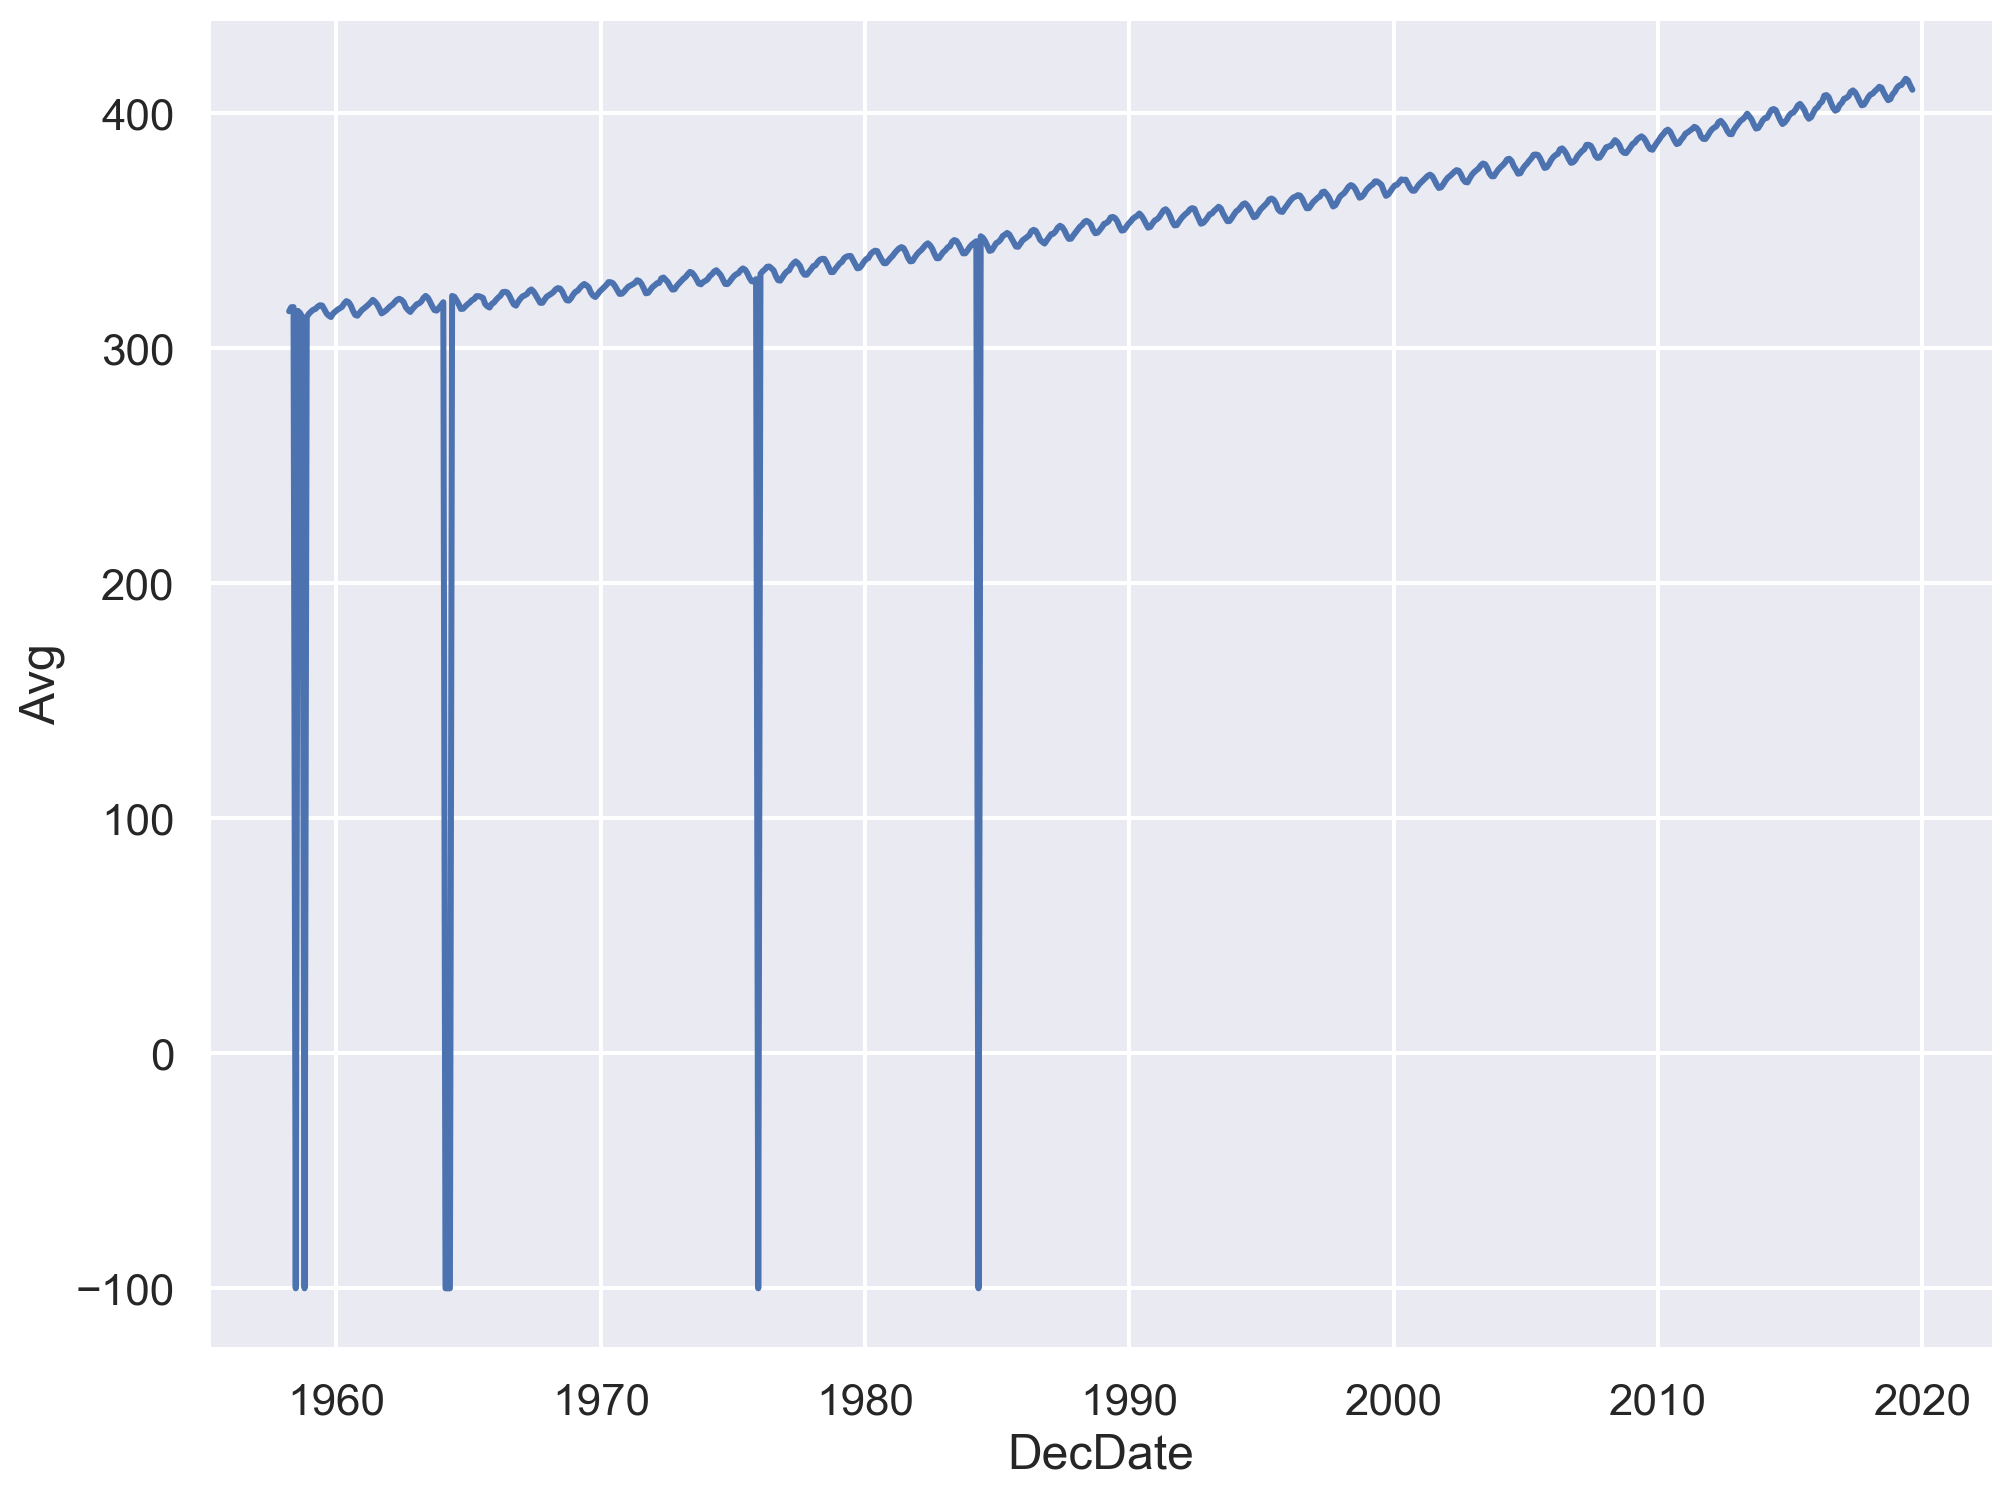

In [51]:
#| code-fold: true
sns.lineplot(x='DecDate', y='Avg', data=co2);

The code above uses the `seaborn` plotting library (abbreviated `sns`). We will cover this in the Visualization lecture, but now you don't need to worry about how it works!

Yikes! Plotting the data uncovered a problem. The sharp vertical lines suggest that we have some **missing values**. What happened here?

In [52]:
#| code-fold: false
co2.head()

,Yr,Mo,DecDate,Avg,Int,Trend,Days
0,1958,3,1958.21,315.71,315.71,314.62,-1
1,1958,4,1958.29,317.45,317.45,315.29,-1
2,1958,5,1958.38,317.50,317.50,314.71,-1
3,1958,6,1958.46,-99.99,317.10,314.85,-1
4,1958,7,1958.54,315.86,315.86,314.98,-1


In [53]:
#| code-fold: false
co2.tail()

,Yr,Mo,DecDate,Avg,Int,Trend,Days
733,2019,4,2019.29,413.32,413.32,410.49,26
734,2019,5,2019.38,414.66,414.66,411.20,28
735,2019,6,2019.46,413.92,413.92,411.58,27
736,2019,7,2019.54,411.77,411.77,411.43,23
737,2019,8,2019.62,409.95,409.95,411.84,29


Some data have unusual values like -1 and -99.99.

Let's check the description at the top of the file again.

* -1 signifies a missing value for the number of days `Days` the equipment was in operation that month.
* -99.99 denotes a missing monthly average `Avg`

How can we fix this? First, let's explore other aspects of our data. Understanding our data will help us decide what to do with the missing values.

<br/>


### Sanity Checks: Reasoning about the data
First, we consider the shape of the data. How many rows should we have?

* If chronological order, we should have one record per month.
* Data from March 1958 to August 2019.
* We should have $ 12 \times (2019-1957) - 2 - 4 = 738 $ records.

In [54]:
#| code-fold: false
co2.shape

(738, 7)

Nice!! The number of rows (i.e. records) match our expectations.


Let's now check the quality of each feature.

### Understanding Missing Value 1: `Days`
`Days` is a time field, so let's analyze other time fields to see if there is an explanation for missing values of days of operation.

Let's start with **months**, `Mo`.

Are we missing any records? The number of months should have 62 or 61 instances (March 1957-August 2019).

In [55]:
#| code-fold: false
co2["Mo"].value_counts().sort_index()

Mo
1     61
2     61
3     62
4     62
5     62
6     62
7     62
8     62
9     61
10    61
11    61
12    61
Name: count, dtype: int64

As expected Jan, Feb, Sep, Oct, Nov, and Dec have 61 occurrences and the rest 62.

<br/>

Next let's explore **days** `Days` itself, which is the number of days that the measurement equipment worked.

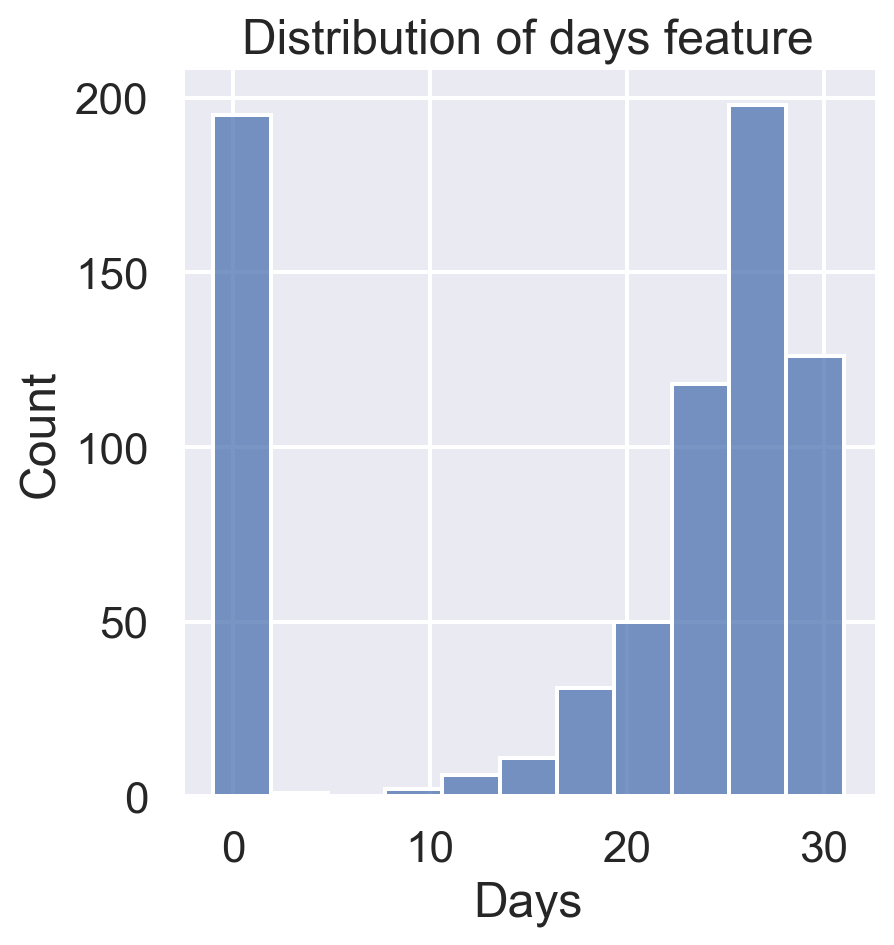

In [56]:
#| code-fold: true
sns.displot(co2['Days']);
plt.title("Distribution of days feature"); # suppresses unneeded plotting output

In terms of data quality, a handful of months have averages based on measurements taken on fewer than half the days. In addition, there are nearly 200 missing values--**that's about 27% of the data**!

<br/>

Finally, let's check the last time feature, **year** `Yr`.

Let's check to see if there is any connection between missing-ness and the year of the recording.

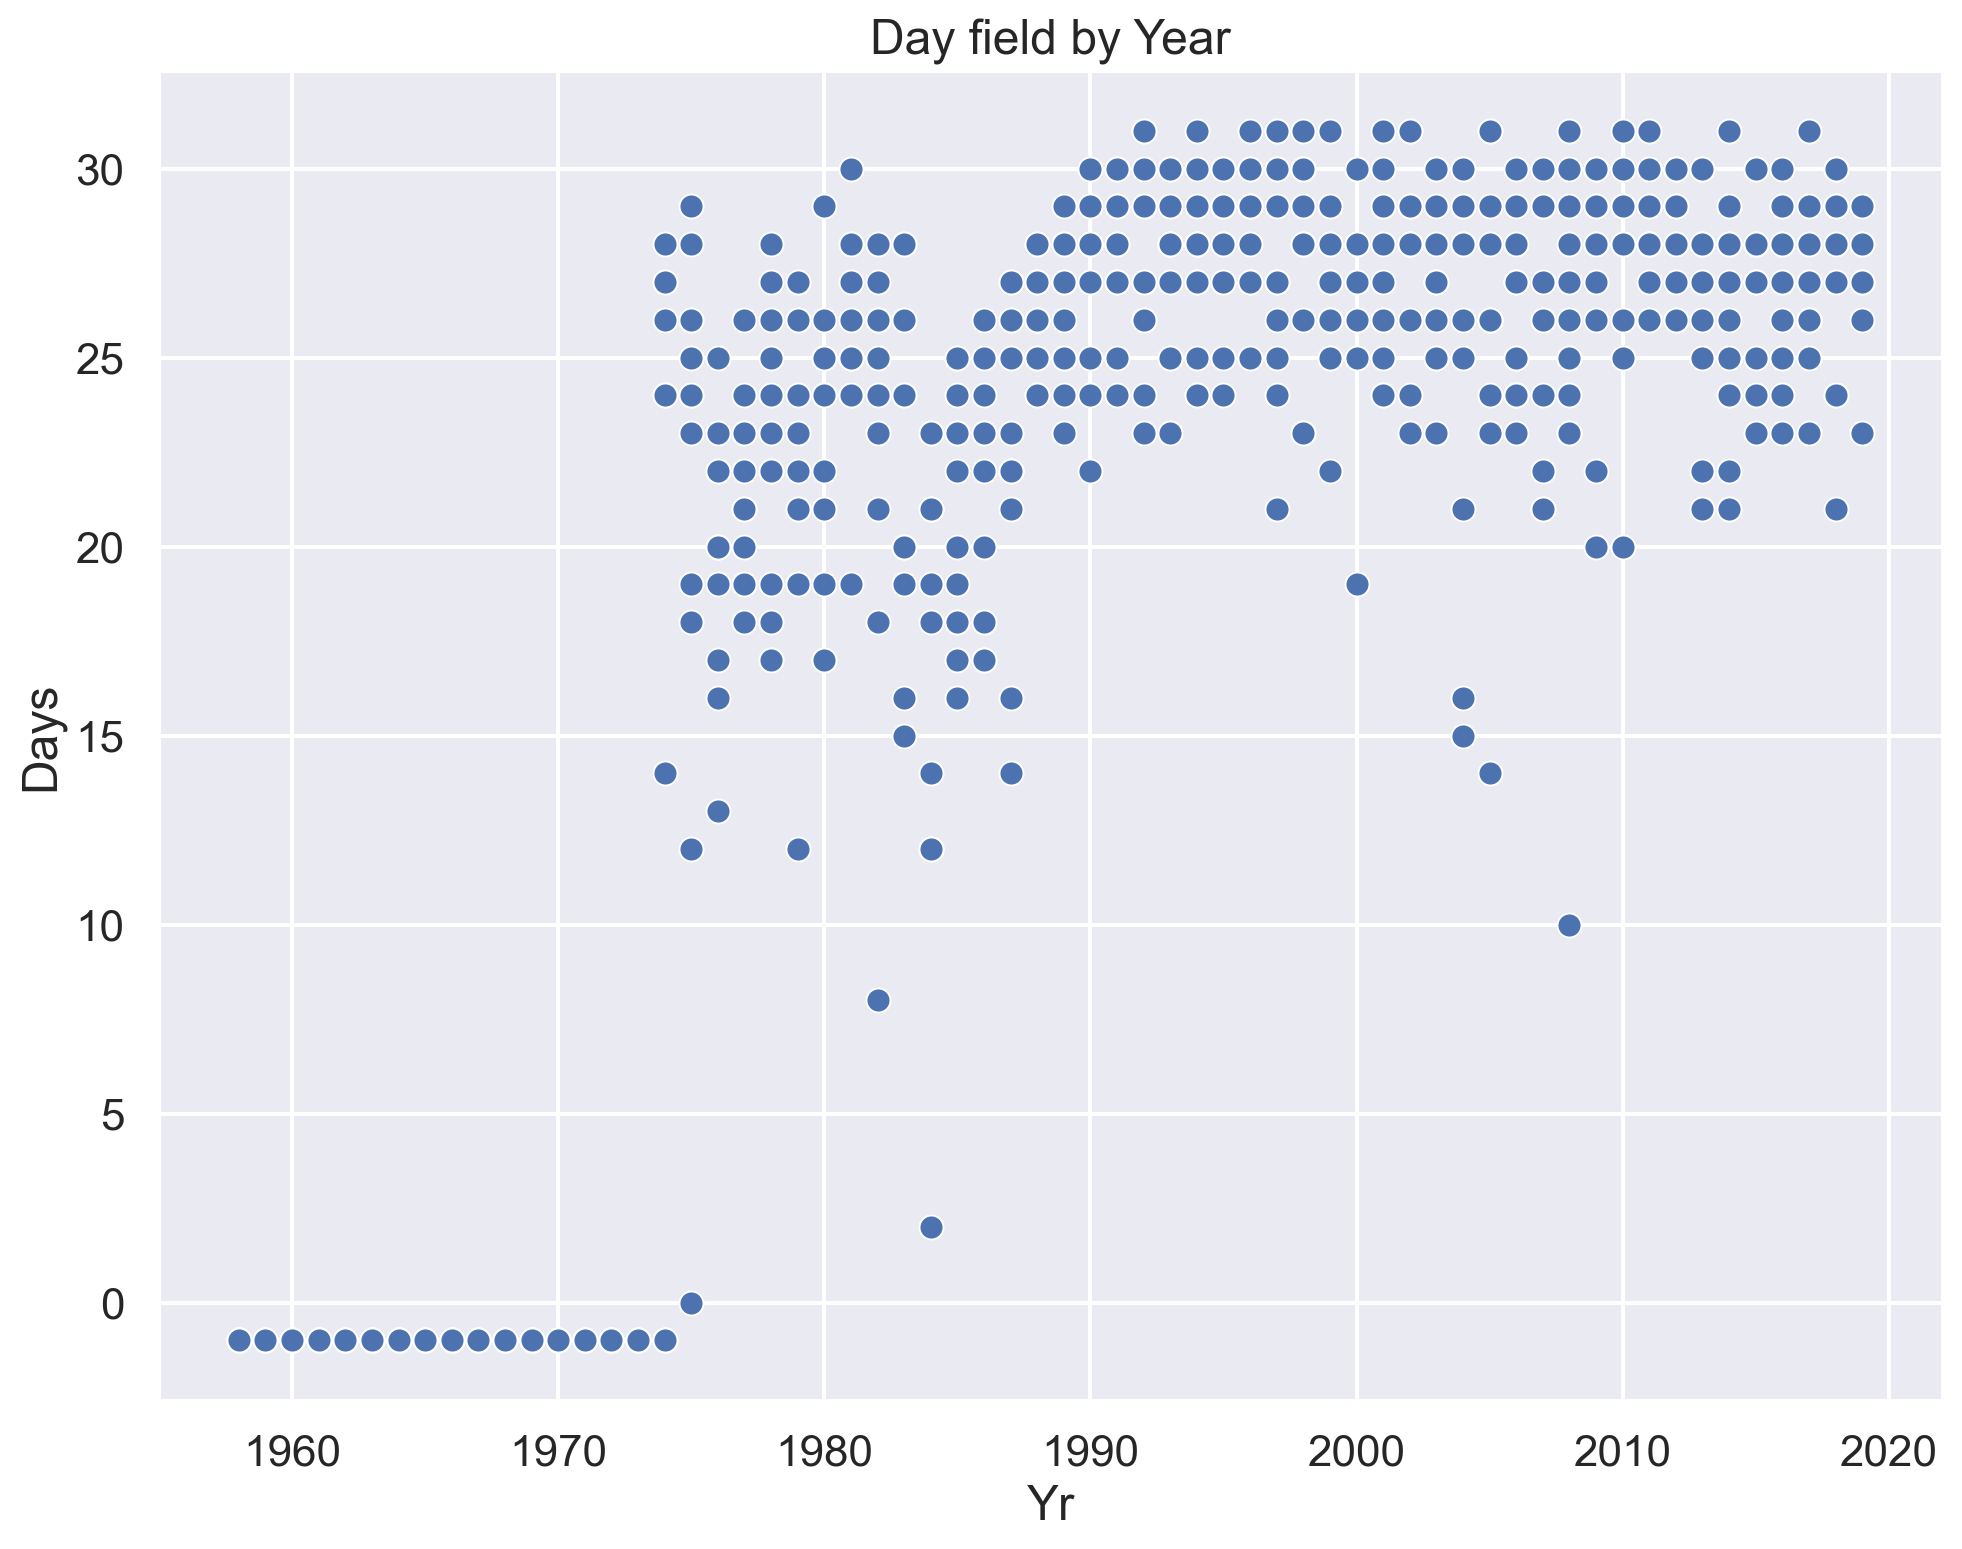

In [57]:
#| code-fold: true
sns.scatterplot(x="Yr", y="Days", data=co2);
plt.title("Day field by Year"); # the ; suppresses output

**Observations**:

* All of the missing data are in the early years of operation.
* It appears there may have been problems with equipment in the mid to late 80s.

**Potential Next Steps**:

* Confirm these explanations through documentation about the historical readings.
* Maybe drop the earliest recordings? However, we would want to delay such action until after we have examined the time trends and assess whether there are any potential problems.

<br/>

### Understanding Missing Value 2: `Avg`
Next, let's return to the -99.99 values in `Avg` to analyze the overall quality of the CO<sub>2</sub> measurements. We'll plot a histogram of the average CO<sub>2</sub> measurements

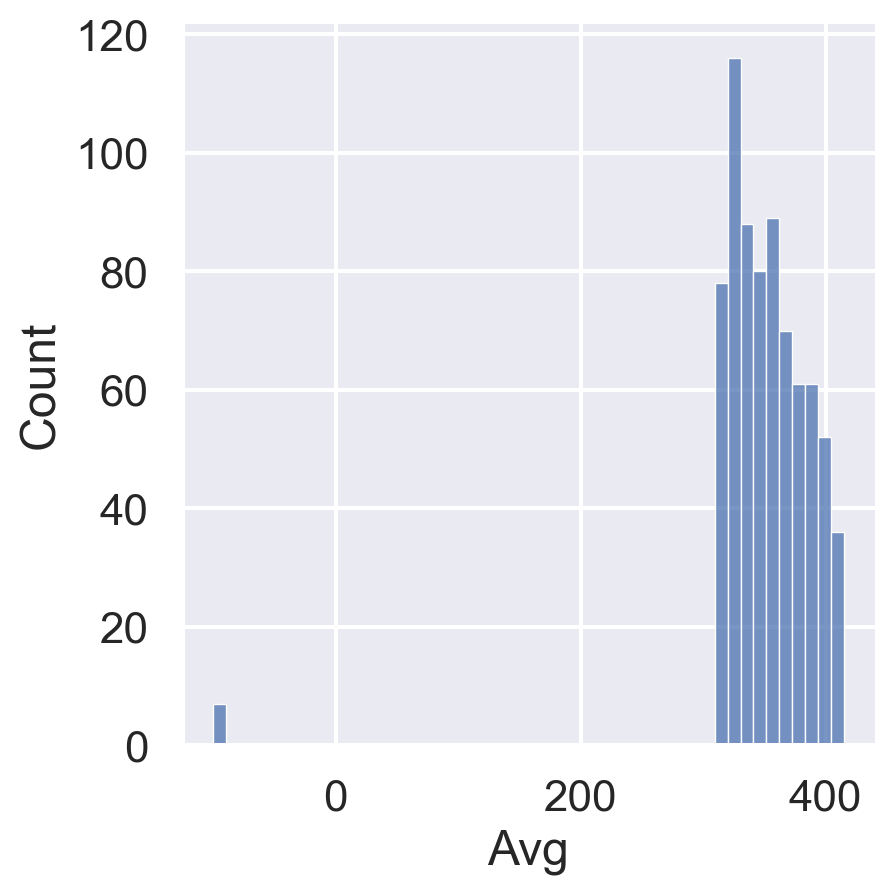

In [58]:
#| code-fold: true
# Histograms of average CO2 measurements
sns.displot(co2['Avg']);

The non-missing values are in the 300-400 range (a regular range of CO<sub>2</sub> levels).

We also see that there are only a few missing `Avg` values (**<1% of values**). Let's examine all of them:

In [59]:
#| code-fold: false
co2[co2["Avg"] < 0]

,Yr,Mo,DecDate,Avg,Int,Trend,Days
3,1958,6,1958.46,-99.99,317.10,314.85,-1
7,1958,10,1958.79,-99.99,312.66,315.61,-1
71,1964,2,1964.12,-99.99,320.07,319.61,-1
72,1964,3,1964.21,-99.99,320.73,319.55,-1
73,1964,4,1964.29,-99.99,321.77,319.48,-1
213,1975,12,1975.96,-99.99,330.59,331.60,0
313,1984,4,1984.29,-99.99,346.84,344.27,2


There doesn't seem to be a pattern to these values, other than that most records also were missing `Days` data.

### Drop, `NaN`, or Impute Missing `Avg` Data?

How should we address the invalid `Avg` data?

1. Drop records
2. Set to NaN
3. Impute using some strategy

Remember we want to fix the following plot:

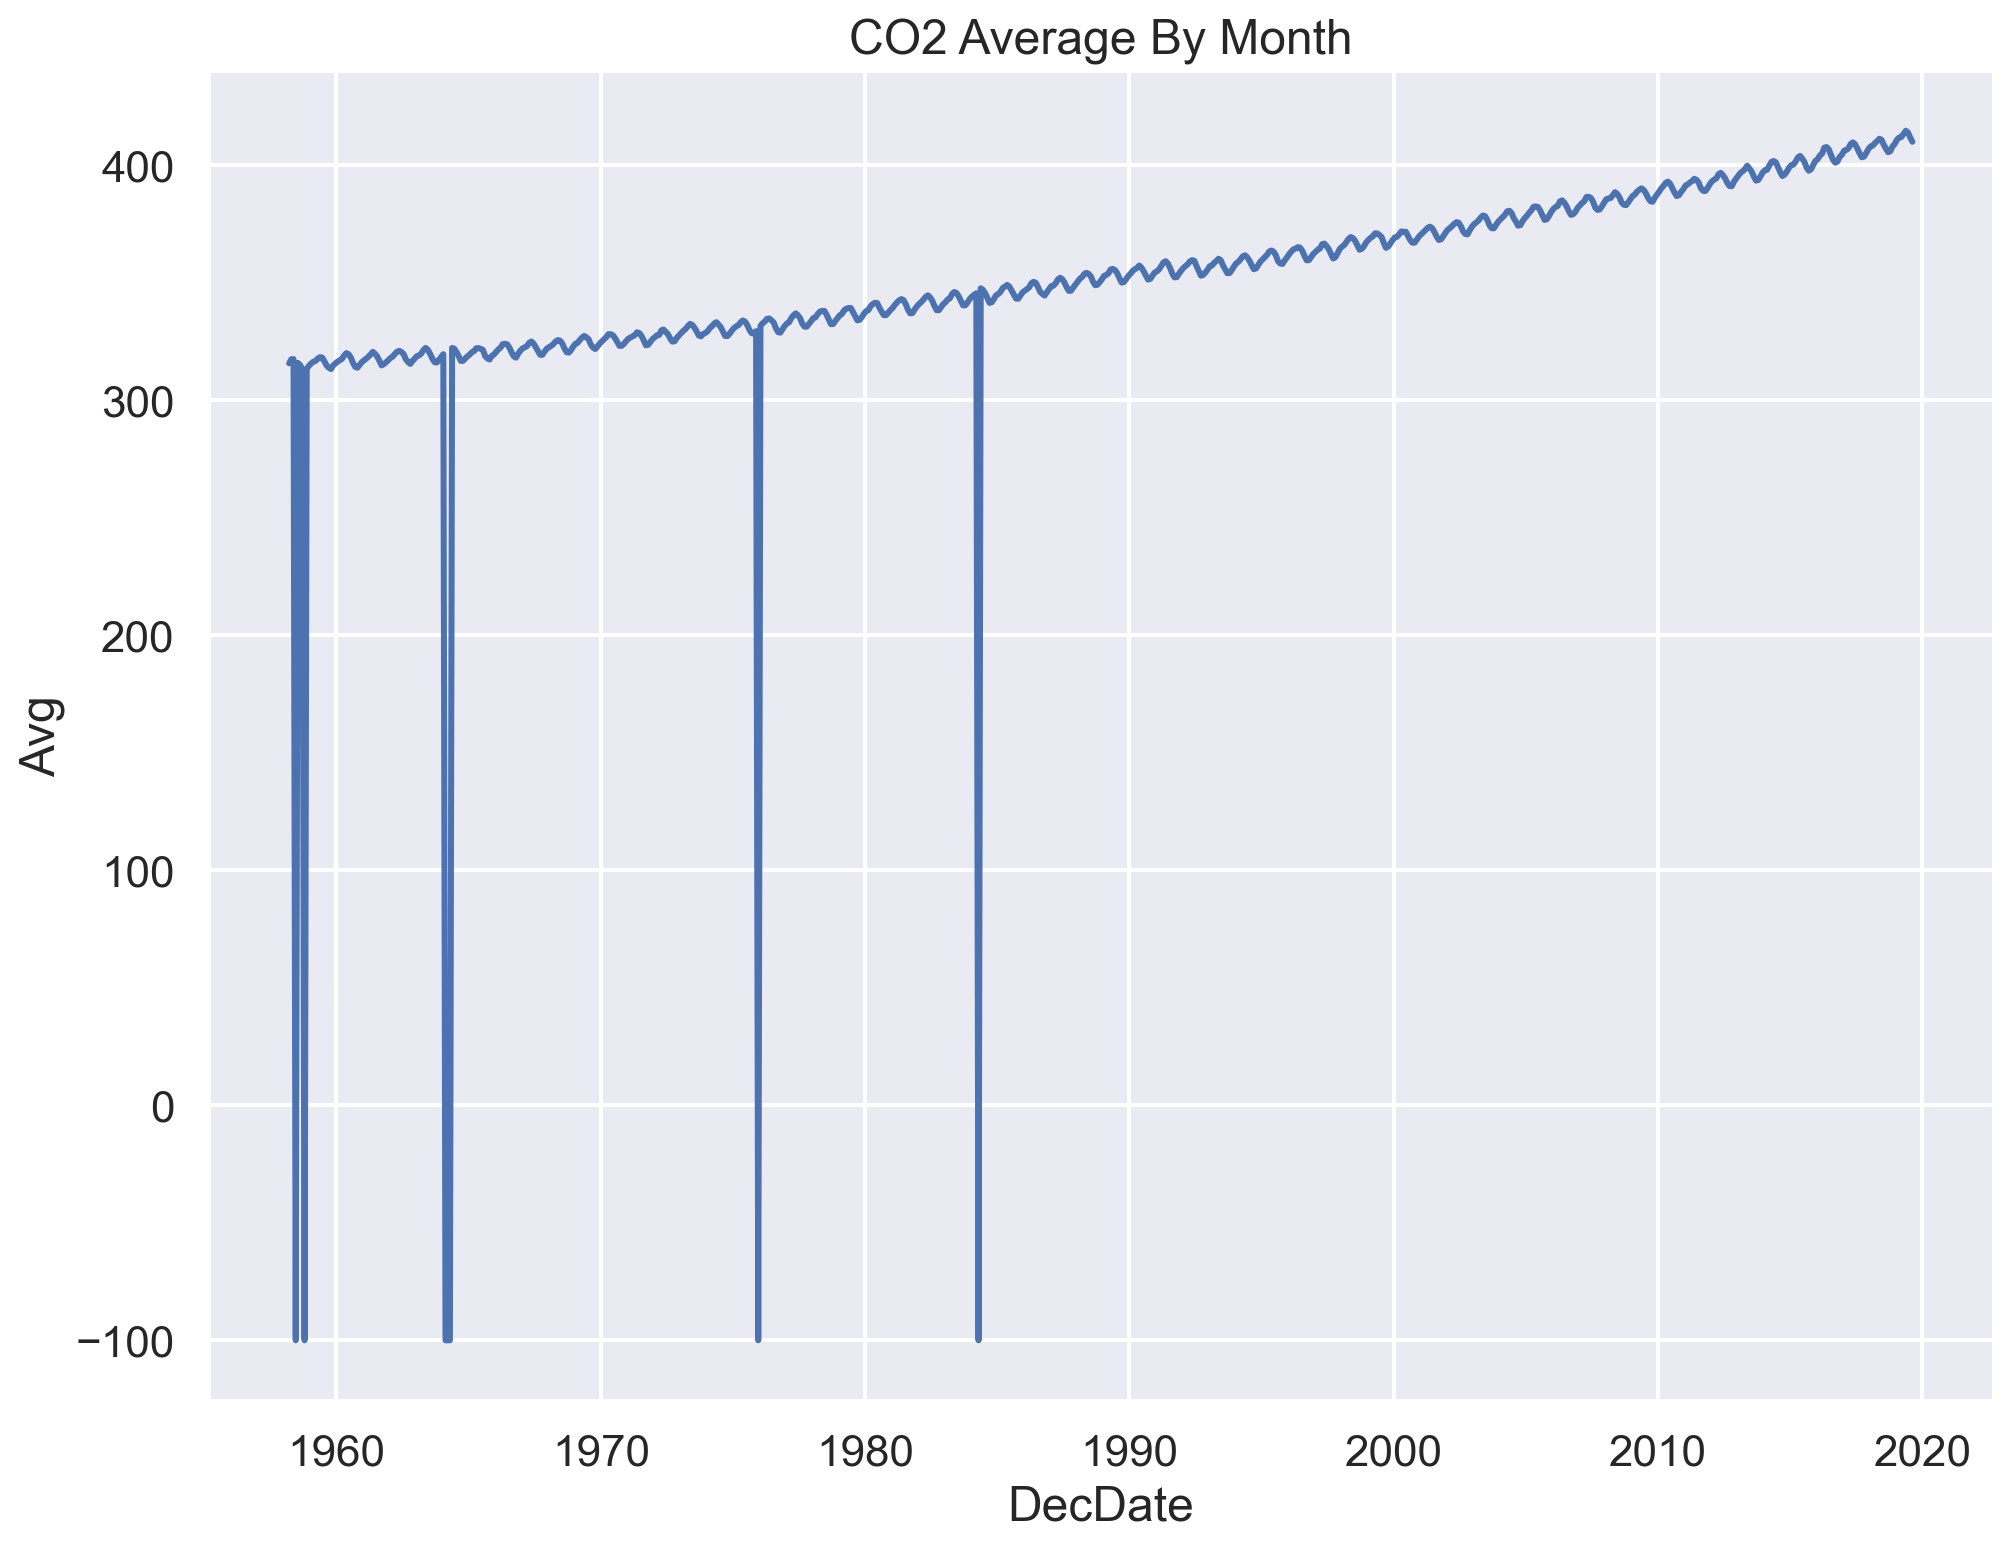

In [60]:
#| code-fold: true
sns.lineplot(x='DecDate', y='Avg', data=co2)
plt.title("CO2 Average By Month");

Since we are plotting `Avg` vs `DecDate`, we should just focus on dealing with missing values for `Avg`.


Let's consider a few options:
1. Drop those records
2. Replace -99.99 with NaN
3. Substitute it with a likely value for the average CO<sub>2</sub>?

What do you think are the pros and cons of each possible action?

Let's examine each of these three options.

In [61]:
#| code-fold: false
# 1. Drop missing values
co2_drop = co2[co2['Avg'] > 0]
co2_drop.head()

,Yr,Mo,DecDate,Avg,Int,Trend,Days
0,1958,3,1958.21,315.71,315.71,314.62,-1
1,1958,4,1958.29,317.45,317.45,315.29,-1
2,1958,5,1958.38,317.50,317.50,314.71,-1
4,1958,7,1958.54,315.86,315.86,314.98,-1
5,1958,8,1958.62,314.93,314.93,315.94,-1


In [62]:
#| code-fold: false
# 2. Replace NaN with -99.99
co2_NA = co2.replace(-99.99, np.nan)
co2_NA.head()

,Yr,Mo,DecDate,Avg,Int,Trend,Days
0,1958,3,1958.21,315.71,315.71,314.62,-1
1,1958,4,1958.29,317.45,317.45,315.29,-1
2,1958,5,1958.38,317.50,317.50,314.71,-1
3,1958,6,1958.46,NaN,317.10,314.85,-1
4,1958,7,1958.54,315.86,315.86,314.98,-1


We'll also use a third version of the data.

First, we note that the dataset already comes with a **substitute value** for the -99.99.

From the file description:

>  The `interpolated` column includes average values from the preceding column (`average`)
and **interpolated values** where data are missing.  Interpolated values are
computed in two steps...

The `Int` feature has values that exactly match those in `Avg`, except when `Avg` is -99.99, and then a **reasonable** estimate is used instead.

So, the third version of our data will use the `Int` feature instead of `Avg`.

In [63]:
#| code-fold: false
# 3. Use interpolated column which estimates missing Avg values
co2_impute = co2.copy()
co2_impute['Avg'] = co2['Int']
co2_impute.head()

,Yr,Mo,DecDate,Avg,Int,Trend,Days
0,1958,3,1958.21,315.71,315.71,314.62,-1
1,1958,4,1958.29,317.45,317.45,315.29,-1
2,1958,5,1958.38,317.50,317.50,314.71,-1
3,1958,6,1958.46,317.10,317.10,314.85,-1
4,1958,7,1958.54,315.86,315.86,314.98,-1


What's a **reasonable** estimate?

To answer this question, let's zoom in on a short time period, say the measurements in 1958 (where we know we have two missing values).

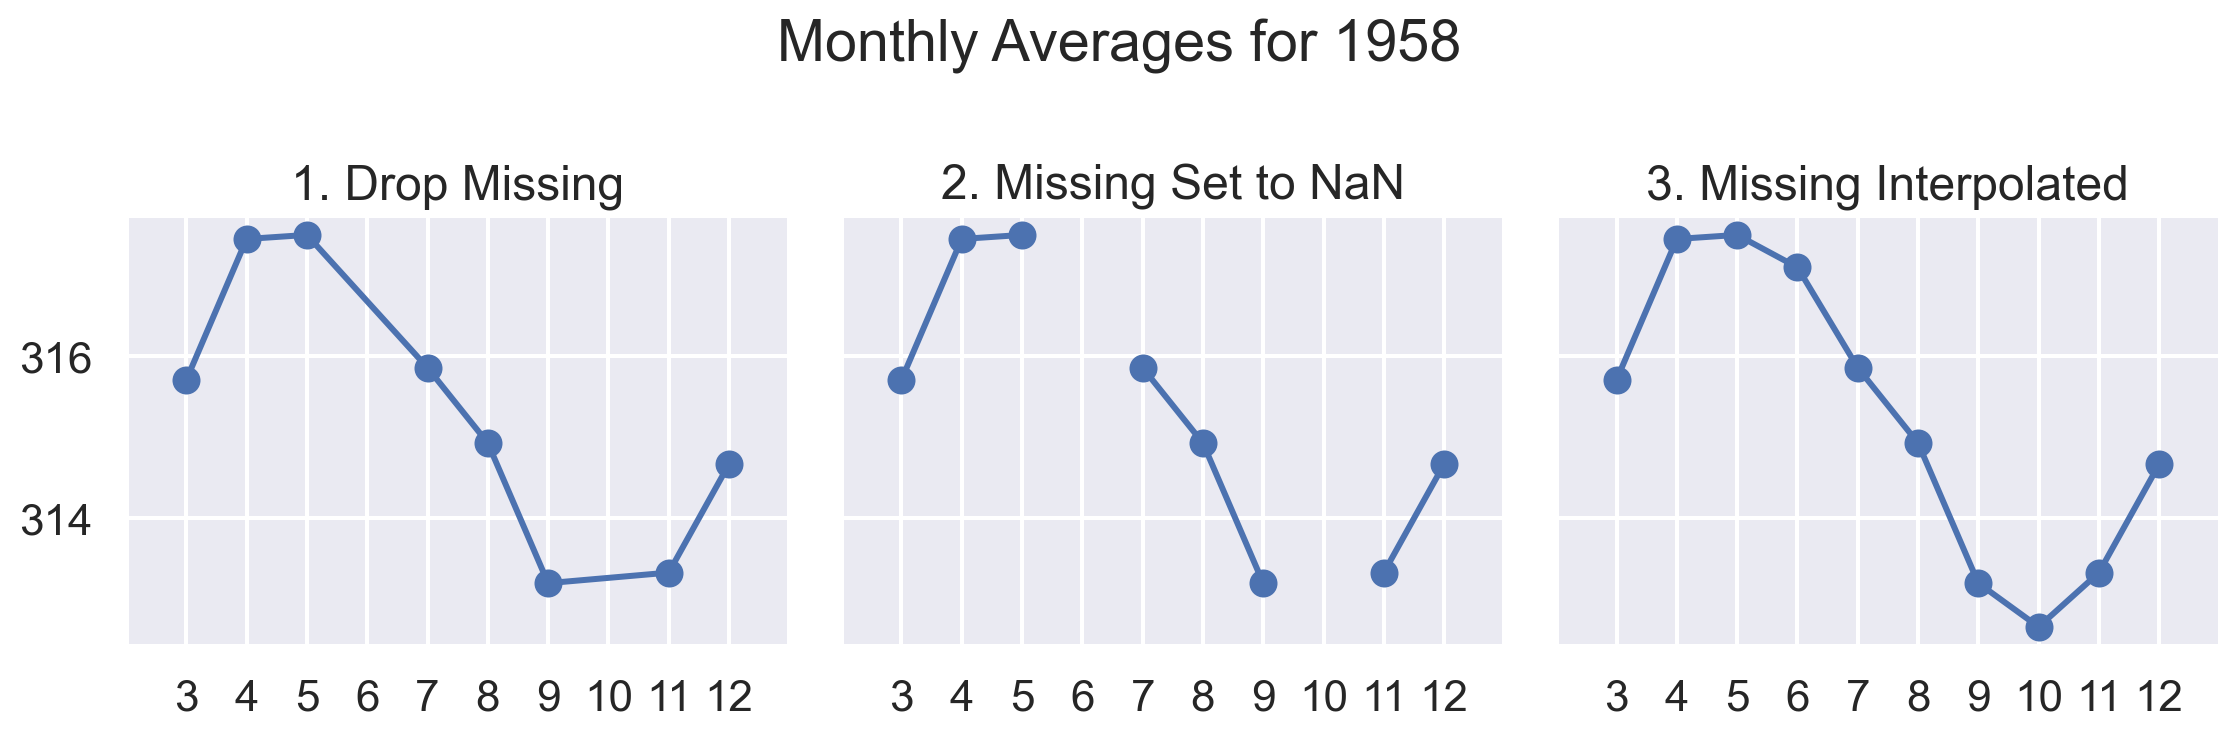

In [64]:
#| code-fold: true
# results of plotting data in 1958

def line_and_points(data, ax, title):
    # assumes single year, hence Mo
    ax.plot('Mo', 'Avg', data=data)
    ax.scatter('Mo', 'Avg', data=data)
    ax.set_xlim(2, 13)
    ax.set_title(title)
    ax.set_xticks(np.arange(3, 13))

def data_year(data, year):
    return data[data["Yr"] == 1958]
    
# uses matplotlib subplots
# you may see more next week; focus on output for now
fig, axes = plt.subplots(ncols = 3, figsize=(12, 4), sharey=True)

year = 1958
line_and_points(data_year(co2_drop, year), axes[0], title="1. Drop Missing")
line_and_points(data_year(co2_NA, year), axes[1], title="2. Missing Set to NaN")
line_and_points(data_year(co2_impute, year), axes[2], title="3. Missing Interpolated")

fig.suptitle(f"Monthly Averages for {year}")
plt.tight_layout()

In the big picture since there are only 7 `Avg` values missing (**<1%** of 738 months), any of these approaches would work.

However there is some appeal to **option C, Imputing**:

* Shows seasonal trends for CO<sub>2</sub>
* We are plotting all months in our data as a line plot


Let's replot our original figure with option 3:

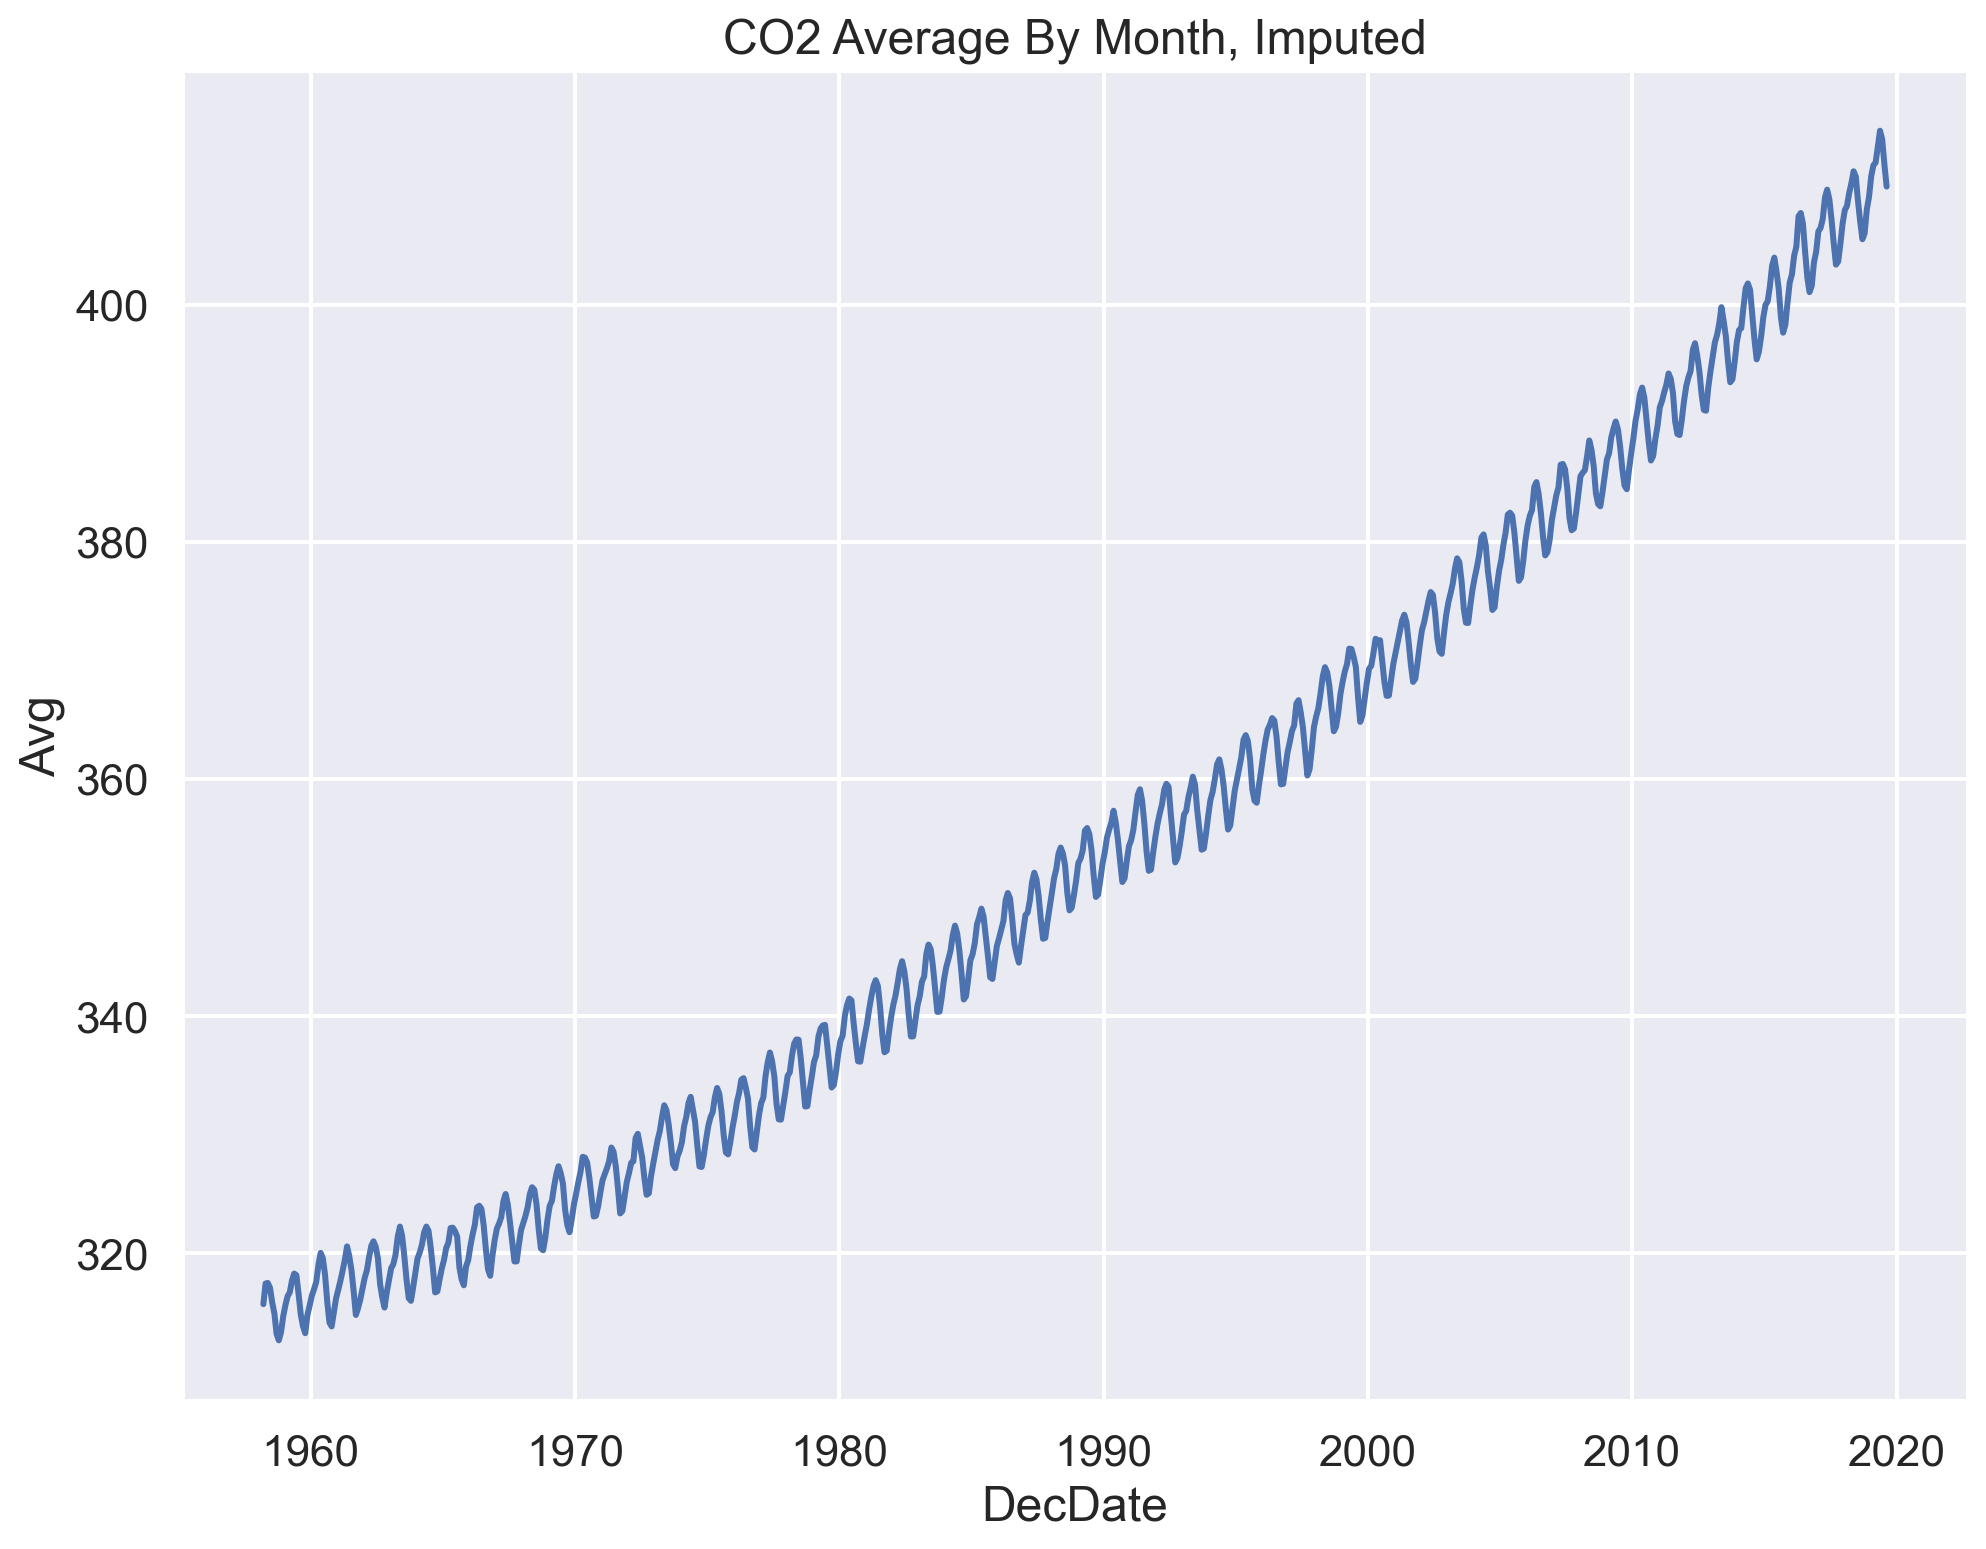

In [65]:
#| code-fold: true
sns.lineplot(x='DecDate', y='Avg', data=co2_impute)
plt.title("CO2 Average By Month, Imputed");

Looks pretty close to what we see on the NOAA [website](https://gml.noaa.gov/ccgg/trends/)!

### Presenting the Data: A Discussion on Data Granularity

From the description:

* Monthly measurements are averages of average day measurements.
* The NOAA GML website has datasets for daily/hourly measurements too.

The data you present depends on your research question.

**How do CO<sub>2</sub> levels vary by season?**

* You might want to keep average monthly data.

**Are CO<sub>2</sub> levels rising over the past 50+ years, consistent with global warming predictions?**

* You might be happier with a **coarser granularity** of average year data!

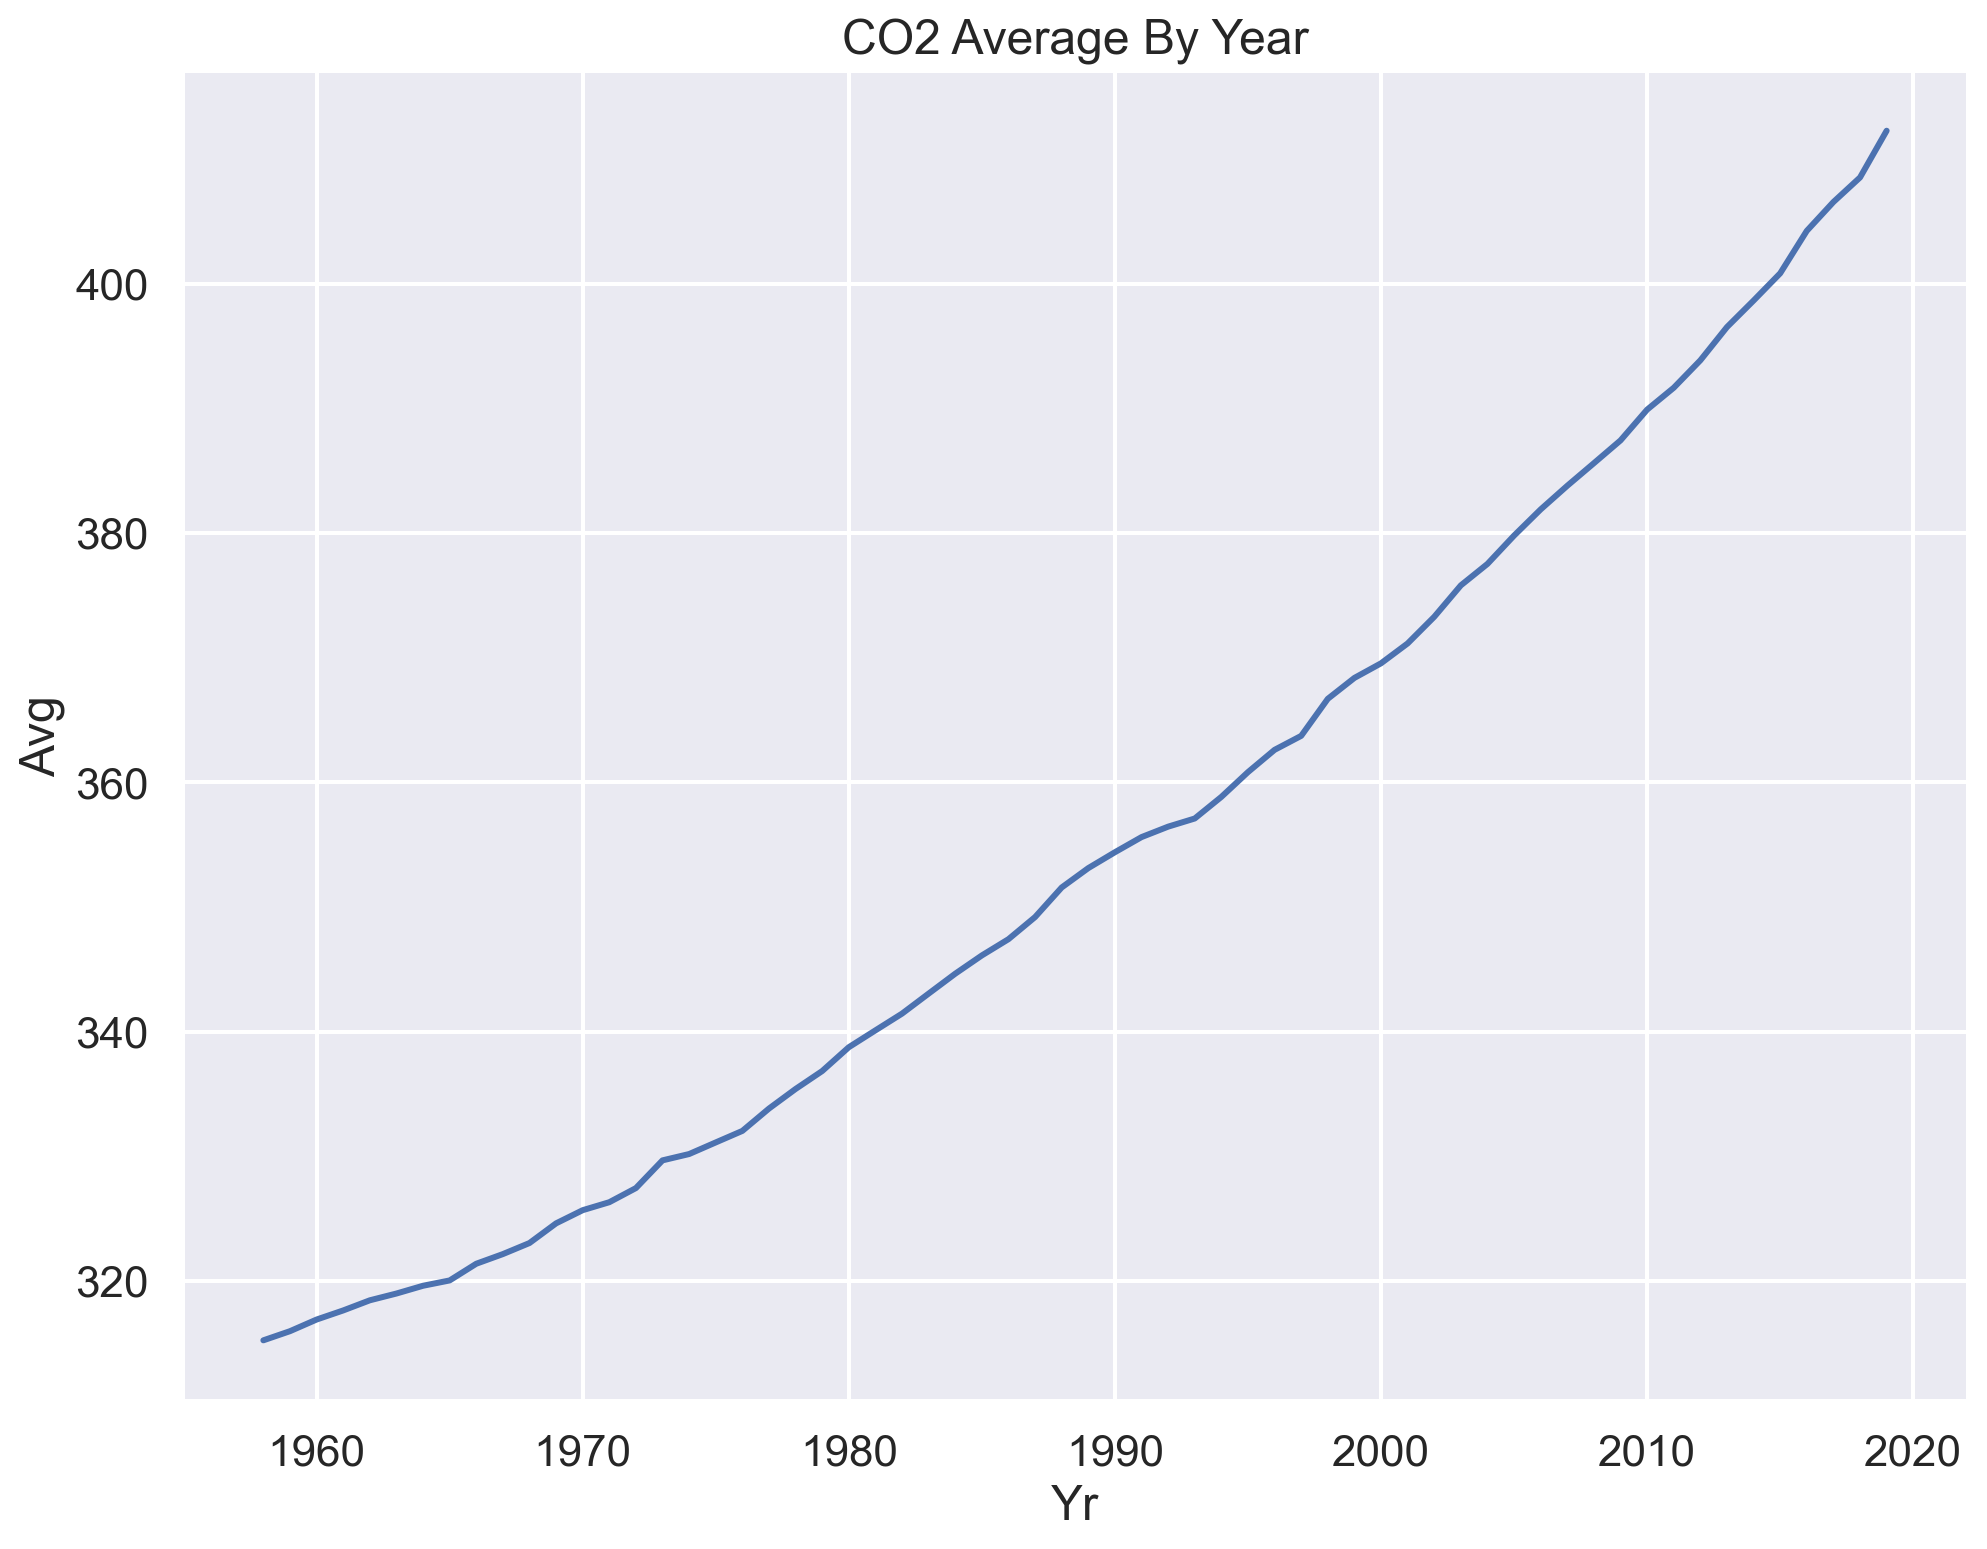

In [66]:
#| code-fold: true
co2_year = co2_impute.groupby('Yr').mean()
sns.lineplot(x='Yr', y='Avg', data=co2_year)
plt.title("CO2 Average By Year");

Indeed, we see a rise by nearly 100 ppm of CO<sub>2</sub> since Mauna Loa began recording in 1958.

## Summary
We went over a lot of content this lecture; let's summarize the most important points: 

### Dealing with Missing Values
There are a few options we can take to deal with missing data:

* Drop missing records
* Keep `NaN` missing values
* Impute using an interpolated column

### EDA and Data Wrangling
There are several ways to approach EDA and Data Wrangling: 

* Examine the **data and metadata**: what is the date, size, organization, and structure of the data? 
* Examine each **field/attribute/dimension** individually.
* Examine pairs of related dimensions (e.g. breaking down grades by major).
* Along the way, we can:
    * **Visualize** or summarize the data.
    * **Validate assumptions** about data and its collection process. Pay particular attention to when the data was collected. 
    * Identify and **address anomalies**.
    * Apply data transformations and corrections (we'll cover this in the upcoming lecture).
    * **Record everything you do!** Developing in Jupyter Notebook promotes *reproducibility* of your own work!
